## Source code (part-2) of the paper:
$A\:data-driven\:approach\:for\:identification\:of\:coal\:related\:lithofacies\:using\:single\:and\:meta\:learner\:ensemble\:classifiers\:from\:well\:log\:data:$<br>$\:A\:case\:study\:from\:Sohagpur\:coal\:field,\:India$<br><br>
$Rupam\,Roy^1$, $Dip\,Kumar\,Singha^{1*}$, $Sayan\,Ghosh^2$, $Laraib\,Abbas^1$, $Tarit\,Narjary^1$, $Debjeet\,Mandal^2$

This notebook contains the complete workflow for developing machine-learning–based single and ensemble classifiers to predict coal, carbonaceous shale, and non-coal facies from high-resolution well-log data. While single classifiers exhibit limited skill in distinguishing carbonaceous facies, the ensemble approaches—particularly stacked, heterogeneous, and selected homogeneous ensembles—demonstrate substantial improvements in both overall and class-wise performance.

The notebook constitutes the primary computational component of the study and includes the following major elements:

1. **Library Imports**:
Loading all required Python libraries and auxiliary functions.

2. **Data Loading**:
Importing training and blind-testing datasets as pandas DataFrames.

3. **Data Description and Preprocessing**:
Dataset overview (excluding variability analyses presented in Part 1), correlation matrix construction, feature selection, and all preprocessing steps including data splitting.

4. **Model Development (Single Classifiers)**:
Training six individual classifiers sequentially and generating their respective classification reports.

5. **Model Validation**:
Evaluating single classifiers using validation sets followed by application to blind-testing datasets.

6. **Litholog Comparisons**:
Visual comparison of true versus predicted lithofacies logs for each single classifier.

7. **Descriptive Visualizations**:
Plotting bar diagrams and related figures presented in the manuscript.

8. **Evaluation Metrics**:
Generating confusion matrices, ROC curves, Jaccard indices, and F1 scores for all models.

9. **Stacked Ensemble Construction**:
Building and evaluating the stacked ensemble model, as discussed in the paper.

10. **Heterogeneous Ensemble Construction**:
Developing and assessing the heterogeneous ensemble classifier.

11. **Homogeneous Ensemble Construction**:
Building each homogeneous ensemble model individually.

12. **Application to Blind Wells**:
Deploying four trained homogeneous ensemble models on two blind wells (Well-4 and Well-5).

13. **Model Performance Summary**:
Comparative evaluation of all single, homogeneous, heterogeneous, and stacked ensemble models using accuracy and F1-score metrics.

14. **Evaluation on Secondary Blind Testing Datasets**:
Applying all trained models to a second blind dataset (without a true litholog) and assessing performance using similarity matrices based on Cohen’s kappa and accuracy heat maps.

The workflow relies extensively on built-in objects and utilities from [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), and several plotting routines are adapted from the works of [Brendon Hall](https://github.com/brendonhall/facies_classification/blob/master/Facies%20Classification%20-%20SVM.ipynb) and [Ryan A. Mardani](https://www.linkedin.com/in/amardani/).
The raw source files (Excel) used for training and testing are confidential and therefore omitted; their directory paths are replaced with underscores. For illustration, the DataFrame corresponding to one representative training well is provided to demonstrate the structure and naming of input and output columns. To execute the notebook successfully, users must replace the placeholder underscores with appropriate file paths pointing to datasets that share identical variable names for all required input and output features.

# Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from imblearn.under_sampling import RandomUnderSampler
import warnings
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification  # replace with your data
from sklearn.neural_network import MLPClassifier
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve


## Importing training data as a pandas dataframe

In [2]:
df_111A = pd.read_excel(r'_.xlsx') # Here, the underscore should be replaced with the data directory


In [3]:
df_113 = pd.read_excel(r'_.xlsx') # Here, the underscore should be replaced with the data directory


In [4]:
df_115 = pd.read_excel(r'_.xlsx') # Here, the underscore should be replaced with the data directory


Below, the input log variables described in the manuscript are given with the required variable names as shown below, to run the entire code.

In [5]:
df_115.describe()

,DEPTH,NGAM,CALP,LSD,HRD,SHN,LONG,SP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
count,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000,42590.000000
mean,267.549579,94.493711,79.717743,2.703229,2.574046,69.310462,57.216396,409.480969,39.292122,63.263429,2.638638,2.195421
std,132.739508,43.077360,3.723658,0.344778,0.414833,46.519090,32.229703,40.602101,16.683427,37.579145,0.376723,0.784164
min,45.100000,21.970000,77.244000,1.348000,1.079000,0.200000,1.400000,337.900000,1.000000,0.900000,1.245000,0.000000
25%,151.572500,63.293000,78.904000,2.472000,2.228000,33.636000,31.855000,363.918000,26.622500,32.863500,2.352000,2.000000
50%,258.045000,87.007000,79.736000,2.779000,2.728000,64.127000,51.545000,436.773000,38.000000,57.968250,2.755500,2.000000
75%,387.517500,115.428000,79.839000,2.958000,2.888000,95.764000,78.800000,444.409000,50.200000,86.963500,2.922500,2.000000
max,493.990000,372.263000,171.309000,3.768000,3.412000,437.109000,233.982000,454.200000,141.364000,269.000000,3.512000,5.000000


Plotting the well log responses of each of the training wells

In [6]:
df_111A = df_111A.sort_values(by='DEPTH')
df_113 = df_113.sort_values(by='DEPTH')
df_115 = df_115.sort_values(by='DEPTH')


mapping = {
    'CARBSHALE': 0,
    'HIGH CARBSHALE': 0,
    'LOW CARBSHALE': 0,
    'COAL': 1,
    'INTERCALATION OF SANDSTONE': 2,
    'SANDSTONE': 2,
    'SANDY SHALE': 3,
    'INTERCALATION OF SHALE': 3,
    'SHALE': 4,
    'SHALY COAL': 5
}

In [7]:
facies_colors = ['#2E86C1', '#000000', '#FFD700', '#c1b32e', '#800000', '#9400D3']
facies_labels = ['CS','COAL','STN','SNYSH','SH','SHY_COAL']

**FUNCTION 1 : CALP, NGAM, SPR, LONG_SHORT AVG, LSD_HRD AVG**

In [8]:
def make_facies_log_plot(logs, facies_colors):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import numpy as np

    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    cluster = np.repeat(np.expand_dims(logs['Encoded_Formation'].values, 1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(18, 8), dpi=900)  # Set high DPI
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    
    im = ax[5].imshow(cluster, interpolation='none', aspect='auto',
                      cmap=cmap_facies, vmin=0, vmax=5)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticklabels(facies_labels)
    cbar.ax.tick_params(labelsize=20)  # Set colorbar tick fontsize
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid(True)
        ax[i].tick_params(labelsize=20)  # Set tick label font size
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    # Axis labels with larger font
    ax[0].set_xlabel("CALP.mm\n", fontsize=18)
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[0].xaxis.set_label_position('top') 
    
    ax[1].set_xlabel("GR.API\n", fontsize=18)
    ax[1].set_xlim(logs.NGAM.min(), logs.NGAM.max())
    ax[1].xaxis.set_label_position('top') 
    
    ax[2].set_xlabel("SHN_LONG.OHMm\n", fontsize=18)
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[2].xaxis.set_label_position('top') 
    
    ax[3].set_xlabel("LSD_HRD.gm/cc\n", fontsize=18)
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[3].xaxis.set_label_position('top') 
    
    ax[4].set_xlabel("SPR.OHM\n", fontsize=18)
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[4].xaxis.set_label_position('top') 
    
    ax[5].set_xlabel('Facies\n', fontsize=18)
    ax[5].xaxis.set_label_position('top') 
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[5].set_xticklabels([])
    
    plt.tight_layout()
    plt.savefig("facies_log_plot_high_res.png", dpi=900, bbox_inches='tight')  # Save at 300 DPI


### Well-1

In [1]:
make_facies_log_plot(df_111A, facies_colors)

In [2]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df_111A['Encoded_Formation'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

# Increasing fontsize and set font style
plt.rcParams.update({'font.size': 22, 'font.family': 'Times New Roman'})

# Ploting the bar chart
ax = facies_counts.plot(kind='bar', color=facies_colors, 
                        title='Facies Distribution')

# Set title fontsize and font style
ax.title.set_fontsize(22)
ax.title.set_fontname('Times New Roman')


# Set tick labels fontsize and font style
ax.tick_params(axis='both', which='major', labelsize=22)

# Set tick labels font style
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Show the plot
plt.show()

facies_counts

### Well-2

In [3]:
make_facies_log_plot(df_113, facies_colors)

In [4]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df_113['Encoded_Formation'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

# Increasing fontsize and set font style
plt.rcParams.update({'font.size': 22, 'font.family': 'Times New Roman'})

# Ploting the bar chart
ax = facies_counts.plot(kind='bar', color=facies_colors, 
                        title='Facies Distribution')

# Set title fontsize and font style
ax.title.set_fontsize(22)
ax.title.set_fontname('Times New Roman')

# Set tick labels fontsize and font style
ax.tick_params(axis='both', which='major', labelsize=22)

# Set tick labels font style
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Show the plot
plt.show()

facies_counts

### Well-3

In [5]:
make_facies_log_plot(df_115, facies_colors)
#plt.savefig("SHRIMPLIN_X1", dpi=400)

In [6]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df_115['Encoded_Formation'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

# Increasing fontsize and set font style
plt.rcParams.update({'font.size': 22, 'font.family': 'Times New Roman'})

# Ploting the bar chart
ax = facies_counts.plot(kind='bar', color=facies_colors, 
                        title='Facies Distribution')

# Set title fontsize and font style
ax.title.set_fontsize(22)
ax.title.set_fontname('Times New Roman')

# Set tick labels fontsize and font style
ax.tick_params(axis='both', which='major', labelsize=22)

# Set tick labels font style
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Show the plot
plt.show()

facies_counts

## The overall training data

In [15]:
Training_df = pd.read_excel(r'_.xlsx')


In [16]:
Training_df

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
0,20.00,178.024,78.223,58.400,50.2635,2.6490,4
1,20.01,176.280,78.201,58.000,50.1455,2.6570,4
2,20.02,172.095,78.219,57.600,50.0270,2.6425,4
3,20.03,166.864,78.219,56.527,49.9090,2.6385,4
4,20.04,164.598,78.214,55.455,49.7905,2.6455,4
...,...,...,...,...,...,...,...
132888,569.96,130.772,209.926,15.200,46.2730,1.9905,2
132889,569.97,132.515,209.317,15.200,46.2180,1.9900,2
132890,569.98,130.938,208.741,15.200,46.1635,1.9855,2
132891,569.99,128.613,208.309,15.200,46.1090,1.9835,2


## Importing Blind Test well data (Well-4)

In [17]:
Blind_Testing_df = pd.read_excel(r'_.xlsx')


In [18]:
Blind_Testing_df

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
0,54.00,107.924,78.913,9.582,107.6545,2.5965,2
1,54.01,104.797,78.904,9.618,107.6545,2.6000,2
2,54.02,108.281,78.913,9.655,107.6545,2.6105,2
3,54.03,112.458,78.913,9.691,107.6545,2.6065,2
4,54.04,108.982,78.926,9.727,107.0730,2.6085,2
...,...,...,...,...,...,...,...
45798,527.96,80.207,57.758,15.655,18.3455,2.7605,2
45799,527.97,78.114,57.758,15.564,18.2635,2.7355,2
45800,527.98,80.207,57.758,15.527,18.1635,2.7140,2
45801,527.99,82.299,57.736,15.491,18.1640,2.6800,2


In [7]:
make_facies_log_plot(Blind_Testing_df, facies_colors)

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = Blind_Testing_df['Encoded_Formation'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

# Increasing fontsize and set font style
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})

# Ploting the bar chart
ax = facies_counts.plot(kind='bar', color=facies_colors, 
                        title='Facies Distribution in the first blind testing well')

# Set title fontsize and font style
ax.title.set_fontsize(16)
ax.title.set_fontname('Times New Roman')

# Set tick labels fontsize and font style
ax.tick_params(axis='both', which='major', labelsize=14)

# Set tick labels font style
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Show the plot
plt.show()

facies_counts

In [21]:
Blind_X_test = Blind_Testing_df.iloc[:, 1:-1]
Blind_X_test

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG
0,107.924,78.913,9.582,107.6545,2.5965
1,104.797,78.904,9.618,107.6545,2.6000
2,108.281,78.913,9.655,107.6545,2.6105
3,112.458,78.913,9.691,107.6545,2.6065
4,108.982,78.926,9.727,107.0730,2.6085
...,...,...,...,...,...
45798,80.207,57.758,15.655,18.3455,2.7605
45799,78.114,57.758,15.564,18.2635,2.7355
45800,80.207,57.758,15.527,18.1635,2.7140
45801,82.299,57.736,15.491,18.1640,2.6800


## Defining a color map for the facies

 'CARBSHALE': 0,
  'COAL': 1,
  'SANDSTONE': 2,
  'SANDY SHALE',: 3,
  'SHALE': 4,
  'SHALY COAL': 5

In [22]:
facies_colors = ['#2E86C1', '#000000', '#FFD700', '#c1b32e', '#800000', '#9400D3']
facies_labels = ['CS','COAL','STN','SNYSH','SH','SHY_COAL']

# 1. cmap_facies
cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

In [9]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = Training_df['Encoded_Formation'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

# Increasing fontsize and set font style
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})

# Ploting the bar chart
ax = facies_counts.plot(kind='bar', color=facies_colors, 
                        title='Facies Distribution: With Original proportion of all the classes\n')

# Set title fontsize and font style
ax.title.set_fontsize(16)
ax.title.set_fontname('Times New Roman')


# Set tick labels fontsize and font style
ax.tick_params(axis='both', which='major', labelsize=14)

# Set tick labels font style
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Show the plot
plt.show()

facies_counts

In [24]:
np.bincount(Training_df["Encoded_Formation"] == 1)

array([130181,   2712], dtype=int64)

In [25]:
132893/(6 * np.bincount(Training_df["Encoded_Formation"] == 1))

array([0.17013876, 8.16697394])

# Under sampling the training data

In [26]:
Training_df.describe()

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
count,132893.000000,132893.000000,132893.000000,132893.000000,132893.000000,132893.000000,132893.000000
mean,255.265695,89.098029,82.019964,36.265817,60.730732,2.699375,2.246213
std,135.019400,39.570922,22.941894,17.304216,30.688811,0.362790,0.838051
min,20.000000,14.646000,76.420000,1.000000,0.900000,1.203500,0.000000
25%,139.770000,59.981000,78.076000,23.200000,37.309500,2.372000,2.000000
50%,250.520000,81.427000,78.917000,31.836000,56.300000,2.826500,2.000000
75%,368.930000,111.417000,79.301000,47.418000,77.873000,2.962000,2.000000
max,570.000000,643.570000,355.030000,141.364000,269.000000,3.684000,5.000000


In [27]:
# Separate features and target variable
X = Training_df.drop(columns=['DEPTH', 'Encoded_Formation'])
y = Training_df['Encoded_Formation']

In [28]:
# Define the class to undersample (e.g., SANDSTONE)
class_to_remove = 2  # Assuming SANDSTONE class is represented by label 2

# Calculate the number of samples to remove to reduce SANDSTONE proportion by approximately 50%
sandstone_count = y.value_counts()[class_to_remove]
total_count = len(y)
num_samples_to_remove = int(sandstone_count * 0.9)

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={class_to_remove: total_count - num_samples_to_remove}, random_state=42)

# Perform undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Concatenate undersampled data into a DataFrame
undersampled_df = pd.concat([X_resampled, y_resampled], axis=1)

# Shuffle the undersampled dataset (optional)
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now, undersampled_df contains the undersampled training data with reduced proportion of the SANDSTONE class


In [29]:
sandstone_count

104553

In [30]:
num_samples_to_remove

94097

In [10]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = undersampled_df['Encoded_Formation'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

# Increasing fontsize and set font style
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})

# Ploting the bar chart
ax = facies_counts.plot(kind='bar', color=facies_colors, 
                        title='Facies Distribution: With the proportion of "majority" (sandstone) class reduced\n')

# Set title fontsize and font style
ax.title.set_fontsize(16)
ax.title.set_fontname('Times New Roman')


# Set tick labels fontsize and font style
ax.tick_params(axis='both', which='major', labelsize=14)

# Set tick labels font style
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Show the plot
plt.show()

facies_counts

In [32]:
undersampled_training_df = undersampled_df

In [33]:
undersampled_training_df.describe()

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
count,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000
mean,93.426151,81.385211,35.341424,55.814988,2.694573,2.487369
std,38.435300,19.910769,18.312741,30.976441,0.387497,1.128144
min,15.518000,76.434000,1.000000,0.900000,1.213500,0.000000
25%,63.991000,78.076000,21.745000,31.127000,2.382000,2.000000
50%,89.622000,78.969000,30.800000,50.172500,2.823500,2.000000
75%,116.648000,79.500000,46.909000,73.254500,2.974000,4.000000
max,621.775000,354.266000,139.745000,268.772500,3.661000,5.000000


In [34]:
facies_colors = ['#2E86C1', '#000000', '#FFD700', '#c1b32e', '#800000', '#9400D3']
facies_labels = ['CS','COAL','STN','SNYSH','SH','SHY_COAL']

# facies_color_map is a dictionary that maps facies labels to their respective colors
# 2. facies_color_map
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

## enumerate(facies_labels): Returns, all the indicieces and corresponding labels of the facies_labels list.     
    
def label_facies(row, labels):
    return labels[int(row['Encoded_Formation'])]
    
undersampled_training_df.loc[:,'FaciesLabels'] = undersampled_training_df.apply(lambda row: label_facies(row, facies_labels), axis=1)


In [1]:
# Save original rcParams to restore later
inline_rc = dict(mpl.rcParams)

# Set Seaborn style and context
#sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.0)  # Larger text

# Create the pairplot with reduced size and high DPI
g = sns.pairplot(
    undersampled_training_df.drop(['Encoded_Formation'], axis=1),
    hue='FaciesLabels',
    palette=facies_color_map,
    hue_order=list(reversed(facies_labels)),
    height=2.2,     # Reduce height of each subplot
    aspect=1        # Width-to-height ratio
)

# Save high DPI image
g.fig.savefig("pairplot_facies_900dpi.png", dpi=900, bbox_inches='tight')

# Restore original matplotlib settings
mpl.rcParams.update(inline_rc)

## Constructing the input MATRIX of FEATURES from undersampled_training_df

In [35]:
undersampled_training_df

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation,FaciesLabels
0,128.156,79.227,19.000,22.8730,3.1080,4,SH
1,80.555,79.839,67.727,121.8365,2.8890,2,STN
2,62.073,79.275,39.418,110.5180,2.9260,2,STN
3,52.309,78.188,64.255,78.8545,2.7365,2,STN
4,107.581,79.257,18.836,28.7725,2.8450,4,SH
...,...,...,...,...,...,...,...
67131,73.058,79.189,40.745,41.6910,2.5290,2,STN
67132,87.181,77.766,30.800,48.7725,2.3225,2,STN
67133,90.843,79.227,14.691,21.0180,3.1110,4,SH
67134,85.263,79.257,21.073,22.1545,2.5410,0,CS


In [36]:
X = undersampled_training_df.iloc[:, :5] # INPUT MATRIX OF FEATURES
X

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG
0,128.156,79.227,19.000,22.8730,3.1080
1,80.555,79.839,67.727,121.8365,2.8890
2,62.073,79.275,39.418,110.5180,2.9260
3,52.309,78.188,64.255,78.8545,2.7365
4,107.581,79.257,18.836,28.7725,2.8450
...,...,...,...,...,...
67131,73.058,79.189,40.745,41.6910,2.5290
67132,87.181,77.766,30.800,48.7725,2.3225
67133,90.843,79.227,14.691,21.0180,3.1110
67134,85.263,79.257,21.073,22.1545,2.5410


In [37]:
y = undersampled_training_df.iloc[:, 5]
y

0        4
1        2
2        2
3        2
4        4
        ..
67131    2
67132    2
67133    4
67134    0
67135    2
Name: Encoded_Formation, Length: 67136, dtype: int64

In [38]:
# Compute correlation matrix
correlation_matrix = X.corr()


In [39]:
correlation_matrix

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG
NGAM,1.000000,-0.021958,-0.104518,-0.289660,0.085401
CALP,-0.021958,1.000000,-0.164504,-0.080137,-0.216495
SPR,-0.104518,-0.164504,1.000000,0.760149,-0.114306
SHN_LONG_AVG,-0.289660,-0.080137,0.760149,1.000000,-0.059996
LSD_HRD_AVG,0.085401,-0.216495,-0.114306,-0.059996,1.000000


In [40]:
undersampled_training_df

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation,FaciesLabels
0,128.156,79.227,19.000,22.8730,3.1080,4,SH
1,80.555,79.839,67.727,121.8365,2.8890,2,STN
2,62.073,79.275,39.418,110.5180,2.9260,2,STN
3,52.309,78.188,64.255,78.8545,2.7365,2,STN
4,107.581,79.257,18.836,28.7725,2.8450,4,SH
...,...,...,...,...,...,...,...
67131,73.058,79.189,40.745,41.6910,2.5290,2,STN
67132,87.181,77.766,30.800,48.7725,2.3225,2,STN
67133,90.843,79.227,14.691,21.0180,3.1110,4,SH
67134,85.263,79.257,21.073,22.1545,2.5410,0,CS


In [41]:
numeric_training_df = undersampled_training_df.iloc[:, :6]
numeric_training_df

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
0,128.156,79.227,19.000,22.8730,3.1080,4
1,80.555,79.839,67.727,121.8365,2.8890,2
2,62.073,79.275,39.418,110.5180,2.9260,2
3,52.309,78.188,64.255,78.8545,2.7365,2
4,107.581,79.257,18.836,28.7725,2.8450,4
...,...,...,...,...,...,...
67131,73.058,79.189,40.745,41.6910,2.5290,2
67132,87.181,77.766,30.800,48.7725,2.3225,2
67133,90.843,79.227,14.691,21.0180,3.1110,4
67134,85.263,79.257,21.073,22.1545,2.5410,0


In [42]:
numeric_training_df

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation
0,128.156,79.227,19.000,22.8730,3.1080,4
1,80.555,79.839,67.727,121.8365,2.8890,2
2,62.073,79.275,39.418,110.5180,2.9260,2
3,52.309,78.188,64.255,78.8545,2.7365,2
4,107.581,79.257,18.836,28.7725,2.8450,4
...,...,...,...,...,...,...
67131,73.058,79.189,40.745,41.6910,2.5290,2
67132,87.181,77.766,30.800,48.7725,2.3225,2
67133,90.843,79.227,14.691,21.0180,3.1110,4
67134,85.263,79.257,21.073,22.1545,2.5410,0


In [43]:
numeric_training_df.shape[1]

6

## The correlation matrix

In [2]:
# Set Seaborn style and larger fonts
sns.set(style="white", context="talk", font_scale=1.2)  # Increased font size

# Create the figure
plt.figure(figsize=(10, 8))  # Reduced overall size

ax = sns.heatmap(
    numeric_training_df.corr(method='spearman'),
    annot=True,
    fmt='.0%',
    #cmap='coolwarm',
    cbar_kws={'label': 'Correlation (%)'},
    annot_kws={"size": 18}  # Increase annotation font size
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylim(len(numeric_training_df)-numeric_training_df.shape[0], 6)

# Save as high-resolution image
plt.tight_layout()
plt.savefig("correlation_matrix_spearman_high_dpi.png", dpi=900, bbox_inches='tight')

# Show plot (optional in Jupyter)
plt.show()

# Preprocessing 

### (Data split)

Using Scikit data split function, we may randomly split the training data into training and test sets. We select 20% of the data for the test set.

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10)

In [45]:
print(X_train)

          NGAM    CALP     SPR  SHN_LONG_AVG  LSD_HRD_AVG
55659   95.550  78.943  11.818       15.5000       3.1795
44330  113.045  77.839  18.927       20.5455       2.9480
12505   90.494  77.856  43.909       83.3270       1.4375
1669    50.216  79.831  38.436       72.6360       2.8860
34271   82.648  79.809  41.218       79.0180       2.9860
...        ...     ...     ...           ...          ...
17904   36.035  77.997  78.509      119.8000       2.0280
37597   63.817  80.851  27.436       36.3180       2.2170
10201   95.027  77.960  28.600       47.5635       2.3115
9372    61.550  79.895  60.600      108.1910       2.7825
50496  121.705  78.490  14.509       35.3270       3.1265

[53708 rows x 5 columns]


In [46]:
print(y_train)

55659    4
44330    4
12505    1
1669     2
34271    2
        ..
17904    0
37597    2
10201    2
9372     2
50496    4
Name: Encoded_Formation, Length: 53708, dtype: int64


In [47]:
print(X_test)

          NGAM     CALP     SPR  SHN_LONG_AVG  LSD_HRD_AVG
32881   85.612  291.020   7.400       30.3185       1.3355
5942    53.529   78.507  25.873       79.9635       2.8885
66367  130.946   78.357  26.455       42.5365       3.1160
49568  111.940   78.930  21.418       32.0275       2.5080
17321   40.975   78.313  20.655       63.8090       2.7900
...        ...      ...     ...           ...          ...
35271  109.151   79.719  16.964       26.5910       3.0020
60873  168.550   77.997  60.327      104.0000       2.9050
501    130.772   78.490  22.273       43.7815       3.1505
21746  106.535   79.318  42.727       52.8725       2.3280
44396  140.536   77.770  28.800       47.9275       2.3425

[13428 rows x 5 columns]


In [48]:
print(y_test)

32881    2
5942     2
66367    2
49568    2
17321    2
        ..
35271    4
60873    5
501      4
21746    2
44396    2
Name: Encoded_Formation, Length: 13428, dtype: int64


In [49]:
log_111A = df_111A.drop(["DEPTH","LSD","HRD","SHN","LONG","SP","Encoded_Formation"], axis='columns')
log_111A

,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG
0,178.024,78.223,58.400,50.2635,2.6490
1,176.280,78.201,58.000,50.1455,2.6570
2,172.095,78.219,57.600,50.0270,2.6425
3,166.864,78.219,56.527,49.9090,2.6385
4,164.598,78.214,55.455,49.7905,2.6455
...,...,...,...,...,...
45597,130.772,209.926,15.200,46.2730,1.9905
45598,132.515,209.317,15.200,46.2180,1.9900
45599,130.938,208.741,15.200,46.1635,1.9855
45600,128.613,208.309,15.200,46.1090,1.9835


In [50]:
log_113 = df_113.drop(["DEPTH","LSD","HRD","SHN","LONG","SP","Encoded_Formation"], axis='columns')
log_115 = df_115.drop(["DEPTH","LSD","HRD","SHN","LONG","SP","Encoded_Formation"], axis='columns')

### Feature scalling

Almost all machine learning models work efficenctly when data is standardized for zero mean and unit variance. Using Scikit preprocessong module:

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [52]:
logs_111A = sc.fit_transform(log_111A)
logs_113 = sc.fit_transform(log_113)
logs_115 = sc.fit_transform(log_115)

In [53]:
logs_115

array([[-0.04022372, -0.00664497,  0.77478268,  0.04259251, -0.1423811 ],
       [-0.02808262, -0.00664497,  0.75734002,  0.04887266, -0.1158361 ],
       [ 0.01644245, -0.01255321,  0.73989736,  0.05516612, -0.09061835],
       ...,
       [ 1.23883904, -0.663265  , -2.28325805, -1.6568807 , -0.73964357],
       [ 1.19027468, -0.65977377, -2.28325805, -1.6568807 , -0.75291607],
       [ 1.27391588, -0.65977377, -2.28325805, -1.6566412 , -0.75557057]])

In [54]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [55]:
print(X_train)

[[ 0.05554249 -0.12331074 -1.28509369 -1.30399818  1.25081742]
 [ 0.5086657  -0.17827405 -0.89750706 -1.14112449  0.65348238]
 [-0.0754087  -0.17742769  0.46452543  0.88552389 -3.24403199]
 ...
 [ 0.04199671 -0.17224999 -0.37012974 -0.26895696 -0.98886644]
 [-0.82506279 -0.07591484  1.37452801  1.68815819  0.22644588]
 [ 0.73296104 -0.14586362 -1.13837887 -0.66396318  1.11406253]]


In [56]:
print(X_test)

[[-0.20185325 10.43507119 -1.5259655  -0.82564247 -3.50722065]
 [-1.03280793 -0.14501727 -0.51880729  0.77694681  0.49995566]
 [ 0.97230438 -0.15248511 -0.48707633 -0.43123345  1.08696958]
 ...
 [ 0.96779775 -0.14586362 -0.71508129 -0.39104363  1.17598927]
 [ 0.34005569 -0.10464114  0.40008214 -0.09757723 -0.94629181]
 [ 1.22068686 -0.18170926 -0.35922563 -0.25720668 -0.90887773]]


In [57]:
X_blind = sc.transform(Blind_X_test)

In [58]:
X_blind

array([[ 0.37603101, -0.12480431, -1.40700165,  1.67083944, -0.25348637],
       [ 0.29504122, -0.12525238, -1.40503891,  1.67083944, -0.24445539],
       [ 0.38527736, -0.12480431, -1.40302165,  1.67083944, -0.21736244],
       ...,
       [-0.34184359, -1.1780188 , -1.08287695, -1.21801778,  0.04969664],
       [-0.28766047, -1.17911408, -1.08483969, -1.21800164, -0.03803291],
       [-0.15217676, -1.17911408, -1.08680243, -1.21859884, -0.11802162]])

In [59]:
logs_117 = X_blind

In [60]:
y_blind = Blind_Testing_df['Encoded_Formation'].values

In [61]:
y_blind

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

## Feature scalling and the density distribution plots of the scaled logs

In [3]:
# Variables
Variables = ["NGAM", "CALP", "SPR", "RES", "DENS"]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(18, 10), dpi=600)

# Plot for Training Well 1
for i in range(logs_111A.shape[1]):
    sns.kdeplot(logs_111A[:, i], ax=axs[0, 0], label=f"{Variables[i]}")
    sns.histplot(logs_111A[:, i], ax=axs[0, 0], kde=True, stat='density')
axs[0, 0].set_xlim(-5, 5)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlabel("Logs after feature scaling", fontsize=27, fontname='Times New Roman')
axs[0, 0].set_ylabel("Density distribution", fontsize=27, fontname='Times New Roman')
axs[0, 0].tick_params(axis='x', labelsize=26)
axs[0, 0].tick_params(axis='y', labelsize=26)
axs[0, 0].set_title("Training Well - 1", fontsize=27.5, fontname='Times New Roman')
# axs[0, 0].legend(fontsize=20)

# Plot for Training Well 2
for i in range(logs_113.shape[1]):
    sns.kdeplot(logs_113[:, i], ax=axs[0, 1], label=f"{Variables[i]}")
    sns.histplot(logs_113[:, i], ax=axs[0, 1], kde=True, stat='density')
axs[0, 1].set_xlim(-5, 5)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xlabel("Logs after feature scaling", fontsize=27, fontname='Times New Roman')
axs[0, 1].set_ylabel("Density distribution", fontsize=27, fontname='Times New Roman')
axs[0, 1].tick_params(axis='x', labelsize=26)
axs[0, 1].tick_params(axis='y', labelsize=26)
axs[0, 1].set_title("Training Well - 2", fontsize=27.5, fontname='Times New Roman')
axs[0, 1].legend(fontsize=20)

# Plot for Training Well 3
for i in range(logs_115.shape[1]):
    sns.kdeplot(logs_115[:, i], ax=axs[1, 0], label=f"{Variables[i]}")
    sns.histplot(logs_115[:, i], ax=axs[1, 0], kde=True, stat='density')
axs[1, 0].set_xlim(-5, 5)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel("Logs after feature scaling", fontsize=27, fontname='Times New Roman')
axs[1, 0].set_ylabel("Density distribution", fontsize=27, fontname='Times New Roman')
axs[1, 0].tick_params(axis='x', labelsize=26)
axs[1, 0].tick_params(axis='y', labelsize=26)
axs[1, 0].set_title("Training Well - 3", fontsize=27.5, fontname='Times New Roman')
# axs[1, 0].legend(fontsize=20)

# Plot for Testing Well (2, 2)
for i in range(logs_117.shape[1]):
    sns.kdeplot(logs_117[:, i], ax=axs[1, 1], label=f"{Variables[i]}")
    sns.histplot(logs_117[:, i], ax=axs[1, 1], kde=True, stat='density')
axs[1, 1].set_xlim(-5, 5)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlabel("Logs after feature scaling", fontsize=27, fontname='Times New Roman')
axs[1, 1].set_ylabel("Density distribution", fontsize=27, fontname='Times New Roman')
axs[1, 1].tick_params(axis='x', labelsize=26)
axs[1, 1].tick_params(axis='y', labelsize=26)
axs[1, 1].set_title("Blind testing Well - 4", fontsize=27.5, fontname='Times New Roman')
# axs[1, 1].legend(fontsize=20)

# Save figure
plt.tight_layout()
plt.savefig("Feature_scalling_Fig_7.png", dpi=600, bbox_inches='tight')

# Final layout
plt.show()

# # Suppress warnings
# warnings.filterwarnings("ignore")


# Training

### Model parameter selection for SVM Classifier

In [63]:
from sklearn import svm

In [64]:
C = 100
gamma = 0.001
kernel = 'rbf'

# Defining class weights
class_weights = {0: 3, 1: 5, 2: 1, 3: 2, 4: 2, 5: 4}  # Adjust the weights for specific classes

# Create the SVM model with class weighting
SVM_model = svm.SVC(C=C, gamma=gamma, kernel=kernel, probability=True, class_weight=class_weights, decision_function_shape='ovo')

# Fit the model with tqdm progress bar
SVM_model.fit(X_train, y_train)

# Print a message indicating the completion of training
print("Training completed.")


Training completed.


In [65]:
yhat_SVM = SVM_model.predict(X_test)

#### Model Evaluation and confusion matrix ([Ryan A. Mardani](https://www.linkedin.com/in/amardani/))
There are sevral metrices aviable to see how model perfrom on dataset and prediction. The basics for all types of evaluation is similar; how far/close the predicted data is from actual data. 

It is a 2D array of predicted and actual target label. The entries of confusion matrix C[i][j] are equal to the number of observations predicted to have facies j, but are known to have facies i.

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics. See the file classification_utilities in Scikit-learn.

# Classification report function

In [66]:
import numpy as np

def display_cm(cm, labels, hide_zeros=False, display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision and F1 score.
       Based on Zach Guo's print_cm gist at
       https://gist.github.com/zachguo/10296432
    """

    precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
    recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    #print total_precision
    
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + " Pred", end=" ")
    for label in labels: 
        print("%{0}s".format(columnwidth) % label, end=" ")
    print("%{0}s".format(columnwidth) % 'Total')
    print()
    print("    " + " True")
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)): 
            cell = "%{0}d".format(columnwidth) % cm[i, j]
            if hide_zeros:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            print(cell, end=" ")
        print("%{0}d".format(columnwidth) % sum(cm[i,:]))
        
        print()
        
    if display_metrics:
        print()
        print("Precision", end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % precision[j]
            print(cell, end=" ")
        print("%{0}.2f".format(columnwidth) % total_precision)
        print()
        print("   Recall", end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % recall[j]
            print(cell, end=" ")
        print("%{0}.2f".format(columnwidth) % total_recall)
        print()
        print("       F1", end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % F1[j]
            print(cell, end=" ")
        print("%{0}.2f".format(columnwidth) % total_F1)
        print()

def display_adj_cm(
        cm, labels, adjacent_facies, hide_zeros=False, 
        display_metrics=False):
    """This function displays a confusion matrix that counts 
       adjacent facies as correct.
    """
    adj_cm = np.copy(cm)
    
    for i in np.arange(0,cm.shape[0]):
        for j in adjacent_facies[i]:
            adj_cm[i][i] += adj_cm[i][j]
            adj_cm[i][j] = 0.0
        
    display_cm(adj_cm, labels, hide_zeros, display_metrics)


In [67]:
from sklearn.metrics import confusion_matrix

conf_SVM = confusion_matrix(y_test, yhat_SVM)
display_cm(conf_SVM, facies_labels, hide_zeros=True, display_metrics=True)

     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      114       58      221       22      223        9      647

    COAL        7      307      150       10       39       23      536

     STN       43      132     6576      152      727       46     7676

   SNYSH       13        7      225      247      357       19      868

      SH       72       24      420      110     2662       53     3341

SHY_COAL       15       63      164        7       41       70      360


Precision     0.43     0.52     0.85     0.45     0.66     0.32     0.73

   Recall     0.18     0.57     0.86     0.28     0.80     0.19     0.74

       F1     0.25     0.54     0.85     0.35     0.72     0.24     0.73



In [68]:
import pandas as pd
import numpy as np

def display_cm_as_dataframe(cm, labels, hide_zeros=False, display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision, and F1 score,
       as a Pandas DataFrame.
    """
    precision = np.diagonal(cm) / cm.sum(axis=0).astype('float')
    recall = np.diagonal(cm) / cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    
    # Create DataFrame for confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    if hide_zeros:
        df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)
    
    if display_metrics:
        # Add precision, recall, and F1 score as additional rows
        df_metrics = pd.DataFrame([precision, recall, F1], 
                                  index=['Precision', 'Recall', 'F1 Score'], 
                                  columns=labels)
        df_metrics['Total'] = [total_precision, total_recall, total_F1]
        df_cm = pd.concat([df_cm, df_metrics])
    
    return df_cm


In [69]:
# Example usage
conf_SVM = confusion_matrix(y_test, yhat_SVM)
df_conf_SVM = display_cm_as_dataframe(conf_SVM, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_SVM)

                   CS        COAL          STN       SNYSH           SH  \
CS         114.000000   58.000000   221.000000   22.000000   223.000000   
COAL         7.000000  307.000000   150.000000   10.000000    39.000000   
STN         43.000000  132.000000  6576.000000  152.000000   727.000000   
SNYSH       13.000000    7.000000   225.000000  247.000000   357.000000   
SH          72.000000   24.000000   420.000000  110.000000  2662.000000   
SHY_COAL    15.000000   63.000000   164.000000    7.000000    41.000000   
Precision    0.431818    0.519459     0.847860    0.450730     0.657446   
Recall       0.176198    0.572761     0.856696    0.284562     0.796767   
F1 Score     0.250274    0.544809     0.852255    0.348870     0.720433   

            SHY_COAL     Total  
CS          9.000000       NaN  
COAL       23.000000       NaN  
STN        46.000000       NaN  
SNYSH      19.000000       NaN  
SH         53.000000       NaN  
SHY_COAL   70.000000       NaN  
Precision   0.3181

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


In [71]:
from sklearn.metrics import f1_score as calculate_f1_score_for_SVM

# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_test, yhat_SVM))
union = np.sum(np.logical_or(y_test, yhat_SVM))
jSVM = intersection / union

# Calculate F1 score
f1SVM = calculate_f1_score_for_SVM(y_test, yhat_SVM, average='weighted')

print("SVM Jaccard index: %.3f" % jSVM)
print("SVM F1-score: %.3f" % f1SVM)


SVM Jaccard index: 0.949
SVM F1-score: 0.729


## Training the RandomForestClassifier

With hyperparameter tunning and runtime monitoring

Obtained Best Parameters from hyper parameter tuning: {'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Defining class weights
# class_weights = {0: 5, 1: 5, 2: 1, 3: 2, 4: 2, 5: 5}

# Create the Random Forest Classifier with class weighting
RFC_model = RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=100, class_weight='balanced')

# Fit the model
RFC_model.fit(X_train, y_train)

# Predict
yhat_RFC = RFC_model.predict(X_test)


In [73]:
from sklearn.metrics import f1_score as calculate_f1_score_for_RFC

# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_test, yhat_RFC))
union = np.sum(np.logical_or(y_test, yhat_RFC))
jRFC = intersection / union

# Calculate F1 score
f1RFC = calculate_f1_score_for_RFC(y_test, yhat_RFC, average='weighted')

print("RFC Jaccard index: %.3f" % jRFC)
print("RFC F1-score: %.3f" % f1RFC)


RFC Jaccard index: 0.997
RFC F1-score: 0.984


In [74]:
conf_RFC = confusion_matrix(y_test, yhat_RFC)
display_cm(conf_RFC, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_RFC = display_cm_as_dataframe(conf_RFC, facies_labels, hide_zeros=True, display_metrics=True)

print(df_conf_RFC)

     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      623                 9                13        2      647

    COAL               517       11                 6        2      536

     STN       10        3     7590       16       56        1     7676

   SNYSH        2        3       18      840        5               868

      SH        4                29        6     3299        3     3341

SHY_COAL        4                 3                 9      344      360


Precision     0.97     0.99     0.99     0.97     0.97     0.98     0.98

   Recall     0.96     0.96     0.99     0.97     0.99     0.96     0.98

       F1     0.97     0.98     0.99     0.97     0.98     0.97     0.98

                   CS        COAL          STN       SNYSH           SH  \
CS         623.000000         NaN     9.000000         NaN    13.000000   
COAL              NaN  517.000000    11.000000         NaN     6.000000   
STN         10.000000    3.000

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


# GradientBoostingClassifier

**GBC classifier does not support class_weight parameter**

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the Gradient Boosting Classifier with class weighting
GBC_CLF = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, 
                                      subsample=0.90, max_features='sqrt')

# Fit the model
GBC_CLF.fit(X_train, y_train)

# Predict
yhat_GBC_CLF = GBC_CLF.predict(X_test)


In [77]:
from sklearn.metrics import f1_score as calculate_f1_score_for_GBC

# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_test, yhat_GBC_CLF))
union = np.sum(np.logical_or(y_test, yhat_GBC_CLF))
jGBC = intersection / union

# Calculate F1 score
f1GBC = calculate_f1_score_for_GBC(y_test, yhat_GBC_CLF, average='weighted')

print("GBC Jaccard index: %.3f" % jGBC)
print("GBC F1-score: %.3f" % f1GBC)


GBC Jaccard index: 0.966
GBC F1-score: 0.821


In [78]:
conf_GBC = confusion_matrix(y_test, yhat_GBC_CLF)
display_cm(conf_GBC, facies_labels, hide_zeros=True, display_metrics=True)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      313        9      179       17      123        6      647

    COAL        6      339      136       11       25       19      536

     STN       20       26     7196      101      327        6     7676

   SNYSH                        275      497       89        7      868

      SH       64       17      505       82     2649       24     3341

SHY_COAL       23       16      153        9       27      132      360


Precision     0.73     0.83     0.85     0.69     0.82     0.68     0.82

   Recall     0.48     0.63     0.94     0.57     0.79     0.37     0.83

       F1     0.58     0.72     0.89     0.63     0.81     0.48     0.82



In [79]:
df_conf_GBC = display_cm_as_dataframe(conf_GBC, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_GBC)

                   CS        COAL          STN       SNYSH           SH  \
CS         313.000000    9.000000   179.000000   17.000000   123.000000   
COAL         6.000000  339.000000   136.000000   11.000000    25.000000   
STN         20.000000   26.000000  7196.000000  101.000000   327.000000   
SNYSH             NaN         NaN   275.000000  497.000000    89.000000   
SH          64.000000   17.000000   505.000000   82.000000  2649.000000   
SHY_COAL    23.000000   16.000000   153.000000    9.000000    27.000000   
Precision    0.734742    0.832924     0.852203    0.693166     0.817593   
Recall       0.483771    0.632463     0.937467    0.572581     0.792876   
F1 Score     0.583411    0.718982     0.892804    0.627129     0.805045   

             SHY_COAL     Total  
CS           6.000000       NaN  
COAL        19.000000       NaN  
STN          6.000000       NaN  
SNYSH        7.000000       NaN  
SH          24.000000       NaN  
SHY_COAL   132.000000       NaN  
Precision  

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


# The decision tree classifier

In [81]:
from sklearn.tree import DecisionTreeClassifier

# Defining class weights
# class_weights = {0: 5, 1: 5, 2: 1, 3: 2, 4: 2, 5: 5}

# Create the Decision Tree Classifier with class weighting
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth=None)

# Fit the model
DT_model.fit(X_train, y_train)

# Predict
yhat_DT = DT_model.predict(X_test)


In [82]:
from sklearn.metrics import f1_score as calculate_f1_score_for_DT

# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_test, yhat_DT))
union = np.sum(np.logical_or(y_test, yhat_DT))
jDT = intersection / union

# Calculate F1 score
f1DT = calculate_f1_score_for_DT(y_test, yhat_DT, average='weighted')

print("DT Jaccard index: %.3f" % jDT)
print("DT F1-score: %.3f" % f1DT)


DT Jaccard index: 0.990
DT F1-score: 0.959


In [83]:
conf_DT = confusion_matrix(y_test, yhat_DT)
display_cm(conf_DT, facies_labels, hide_zeros=True, display_metrics=True)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      580        8       31        2       19        7      647

    COAL        4      507        9        4       10        2      536

     STN       33       22     7437       40      132       12     7676

   SNYSH        6        3       46      801       12               868

      SH       16        3       72       22     3221        7     3341

SHY_COAL        6        5       10        2        6      331      360


Precision     0.90     0.93     0.98     0.92     0.95     0.92     0.96

   Recall     0.90     0.95     0.97     0.92     0.96     0.92     0.96

       F1     0.90     0.94     0.97     0.92     0.96     0.92     0.96



In [84]:
df_conf_DT = display_cm_as_dataframe(conf_DT, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_DT)

                   CS        COAL          STN       SNYSH           SH  \
CS         580.000000    8.000000    31.000000    2.000000    19.000000   
COAL         4.000000  507.000000     9.000000    4.000000    10.000000   
STN         33.000000   22.000000  7437.000000   40.000000   132.000000   
SNYSH        6.000000    3.000000    46.000000  801.000000    12.000000   
SH          16.000000    3.000000    72.000000   22.000000  3221.000000   
SHY_COAL     6.000000    5.000000    10.000000    2.000000     6.000000   
Precision    0.899225    0.925182     0.977909    0.919633     0.947353   
Recall       0.896445    0.945896     0.968864    0.922811     0.964083   
F1 Score     0.897833    0.935424     0.973366    0.921219     0.955645   

             SHY_COAL     Total  
CS           7.000000       NaN  
COAL         2.000000       NaN  
STN         12.000000       NaN  
SNYSH             NaN       NaN  
SH           7.000000       NaN  
SHY_COAL   331.000000       NaN  
Precision  

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


# AdaBoost

In [86]:
from sklearn.ensemble import AdaBoostClassifier

ADB_CLF = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME.R', random_state=None).fit(X_train, y_train)

yhat_ADB_CLF = ADB_CLF.predict(X_test)


C:\Users\reser\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [87]:
from sklearn.metrics import f1_score as calculate_f1_score_for_ADB

# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_test, yhat_ADB_CLF))
union = np.sum(np.logical_or(y_test, yhat_ADB_CLF))
jADB = intersection / union

# Calculate F1 score
f1ADB = calculate_f1_score_for_ADB(y_test, yhat_ADB_CLF, average='weighted')

print("ADB Jaccard index: %.3f" % jADB)
print("ADB F1-score: %.3f" % f1ADB)


ADB Jaccard index: 0.946
ADB F1-score: 0.722


In [88]:
conf_ADB = confusion_matrix(y_test, yhat_ADB_CLF)
display_cm(conf_ADB, facies_labels, hide_zeros=True, display_metrics=True)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      124       39      276       49      137       22      647

    COAL       66      169      180       15       23       83      536

     STN       65      171     6801      284      312       43     7676

   SNYSH                48      333      347      138        2      868

      SH       58       32      659      253     2322       17     3341

SHY_COAL        4       40      202       12       30       72      360


Precision     0.39     0.34     0.80     0.36     0.78     0.30     0.72

   Recall     0.19     0.32     0.89     0.40     0.70     0.20     0.73

       F1     0.26     0.33     0.84     0.38     0.74     0.24     0.72



In [89]:
df_conf_ADB = display_cm_as_dataframe(conf_ADB, facies_labels, hide_zeros=True, display_metrics=True)

print(df_conf_ADB)

                   CS        COAL          STN       SNYSH           SH  \
CS         124.000000   39.000000   276.000000   49.000000   137.000000   
COAL        66.000000  169.000000   180.000000   15.000000    23.000000   
STN         65.000000  171.000000  6801.000000  284.000000   312.000000   
SNYSH             NaN   48.000000   333.000000  347.000000   138.000000   
SH          58.000000   32.000000   659.000000  253.000000  2322.000000   
SHY_COAL     4.000000   40.000000   202.000000   12.000000    30.000000   
Precision    0.391167    0.338677     0.804757    0.361458     0.783930   
Recall       0.191654    0.315299     0.886008    0.399770     0.695001   
F1 Score     0.257261    0.326570     0.843430    0.379650     0.736792   

            SHY_COAL     Total  
CS         22.000000       NaN  
COAL       83.000000       NaN  
STN        43.000000       NaN  
SNYSH       2.000000       NaN  
SH         17.000000       NaN  
SHY_COAL   72.000000       NaN  
Precision   0.3012

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


# XG Boost

In [91]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 5.6 MB/s eta 0:00:27
   -- ------------------------------------- 9.4/150.0 MB 36.7 MB/s eta 0:00:04
   ---- ----------------------------------- 15.5/150.0 MB 46.4 MB/s eta 0:00:03
   ---- ----------------------------------- 15.5/150.0 MB 46.4 MB/s eta 0:00:03
   ---- ----------------------------------- 15.5/150.0 MB 46.4 MB/s eta 0:00:03
   ---- ----------------------------------- 15.5/150.0 MB 46.4 MB/s eta 0:00:03
   ---- ----------------------------------- 15.5/150.0 MB 46.4 MB/s eta 0:00:03
   ---- ----------------------------------- 15.7/150.0 MB 10.3 MB/s eta 0:00:14
   ---- ----------------------------------- 15.7/150.0 MB 10.3 MB/s eta 0:00:14
   ---- ----------------------------------- 16.5/150.0 MB 8.7 MB/s eta 0:00:16
   ------ --------------------------------- 25.4/150.0 MB 11.8 MB/s eta 0:00:11
   -------- ------------------------------- 30.1/150.

In [92]:
from xgboost import XGBClassifier

# Defining class weights
# class_weights = {0: 5, 1: 5, 2: 1, 3: 2, 4: 2, 5: 5}

# Defining the best parameters
best_params = {
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.2,
    'max_depth': 7,
    'min_child_weight': 1,
    'n_estimators': 300,
    'subsample': 0.8
}

# Initialize the XGBoost classifier with the best parameters
clf = XGBClassifier(**best_params, scale_pos_weight='balnced')

# Train the classifier
clf.fit(X_train, y_train)

# Calculate the accuracy score on the training set
sr = clf.score(X_train, y_train)
print("The accuracy score is {:.2f}".format(sr))

# Make predictions on the test set
yhat_XGB = clf.predict(X_test)

# Calculate the proportion of predictions classified as class 1 (coal)
yhat_XGB_frac = len(yhat_XGB[yhat_XGB==1]) / len(yhat_XGB)
print("The proportion of predictions classified as class 1 (coal) is {:.2f}".format(yhat_XGB_frac))


C:\Users\reser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:42:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The accuracy score is 1.00
The proportion of predictions classified as class 1 (coal) is 0.04


In [93]:
from sklearn.metrics import f1_score as calculate_f1_score_for_XGB

# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_test, yhat_XGB))
union = np.sum(np.logical_or(y_test, yhat_XGB))
jXGB = intersection / union

# Calculate F1 score
f1XGB = calculate_f1_score_for_XGB(y_test, yhat_XGB, average='weighted')

print("XGB Jaccard index: %.3f" % jXGB)
print("XGB F1-score: %.3f" % f1XGB)


XGB Jaccard index: 0.997
XGB F1-score: 0.983


In [94]:
conf_XGB = confusion_matrix(y_test, yhat_XGB)
display_cm(conf_XGB, facies_labels, hide_zeros=True, display_metrics=True)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      625                 6                13        3      647

    COAL               514       11        1        8        2      536

     STN        8        6     7576       25       60        1     7676

   SNYSH        1                14      849        4               868

      SH        4        5       29        7     3292        4     3341

SHY_COAL        4        1        4        1        2      348      360


Precision     0.97     0.98     0.99     0.96     0.97     0.97     0.98

   Recall     0.97     0.96     0.99     0.98     0.99     0.97     0.98

       F1     0.97     0.97     0.99     0.97     0.98     0.97     0.98



In [95]:
df_conf_XGB = display_cm_as_dataframe(conf_XGB, facies_labels, hide_zeros=True, display_metrics=True)

print(df_conf_XGB)

                   CS        COAL          STN       SNYSH           SH  \
CS         625.000000         NaN     6.000000         NaN    13.000000   
COAL              NaN  514.000000    11.000000    1.000000     8.000000   
STN          8.000000    6.000000  7576.000000   25.000000    60.000000   
SNYSH        1.000000         NaN    14.000000  849.000000     4.000000   
SH           4.000000    5.000000    29.000000    7.000000  3292.000000   
SHY_COAL     4.000000    1.000000     4.000000    1.000000     2.000000   
Precision    0.973520    0.977186     0.991623    0.961495     0.974253   
Recall       0.965997    0.958955     0.986972    0.978111     0.985334   
F1 Score     0.969744    0.967985     0.989292    0.969732     0.979762   

             SHY_COAL     Total  
CS           3.000000       NaN  
COAL         2.000000       NaN  
STN          1.000000       NaN  
SNYSH             NaN       NaN  
SH           4.000000       NaN  
SHY_COAL   348.000000       NaN  
Precision  

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


#### Table E1, Creating dataframe of model evaluation 

In [97]:
# create dictionary with calculated errors as variables
data_frame1 ={'Model type': ['SVM', 'RFC', 'GBC', 'DT', 'ADB', 'XGB'],
       'Jaccard index': [jSVM, jRFC, jGBC, jDT, jADB, jXGB],
       'Overall F1-Score': [f1SVM, f1RFC, f1GBC, f1DT, f1ADB, f1XGB]
            }
df1 = pd.DataFrame(data_frame1, columns = ['Model type','Jaccard index','Overall F1-Score' ] )
df1_sorted = df1.sort_values(by='Overall F1-Score', ascending=False)

print(df1_sorted.round(2))

  Model type  Jaccard index  Overall F1-Score
1        RFC           1.00              0.98
5        XGB           1.00              0.98
3         DT           0.99              0.96
2        GBC           0.97              0.82
0        SVM           0.95              0.73
4        ADB           0.95              0.72


## Applying the classification model to the blind data (Well-4)

#### Predicting facies for blind well by all models

In [98]:
#SVM
yhat_blind_SVM = SVM_model.predict(X_blind)
Blind_Testing_df['SVM_Pred'] = yhat_blind_SVM


In [99]:
#RFC
yhat_blind_RFC = RFC_model.predict(X_blind)
Blind_Testing_df['RFC_Pred'] = yhat_blind_RFC


In [100]:
#GBC
yhat_blind_GBC = GBC_CLF.predict(X_blind)
Blind_Testing_df['GBC_Pred'] = yhat_blind_GBC


In [101]:
#DT
yhat_blind_DT = DT_model.predict(X_blind)
Blind_Testing_df['DT_Pred'] = yhat_blind_DT


In [102]:
#ADB
yhat_blind_ADB = ADB_CLF.predict(X_blind)
Blind_Testing_df['ADB_Pred'] = yhat_blind_ADB


In [103]:
#XGB
yhat_blind_XGB = clf.predict(X_blind)
Blind_Testing_df['XGB_Pred'] = yhat_blind_XGB


In [104]:
Blind_Testing_df

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred
0,54.00,107.924,78.913,9.582,107.6545,2.5965,2,2,2,2,2,2,2
1,54.01,104.797,78.904,9.618,107.6545,2.6000,2,2,2,2,2,2,2
2,54.02,108.281,78.913,9.655,107.6545,2.6105,2,2,2,2,2,2,2
3,54.03,112.458,78.913,9.691,107.6545,2.6065,2,2,2,2,2,2,2
4,54.04,108.982,78.926,9.727,107.0730,2.6085,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45798,527.96,80.207,57.758,15.655,18.3455,2.7605,2,4,2,2,2,2,2
45799,527.97,78.114,57.758,15.564,18.2635,2.7355,2,2,2,2,2,2,2
45800,527.98,80.207,57.758,15.527,18.1635,2.7140,2,2,2,2,2,2,2
45801,527.99,82.299,57.736,15.491,18.1640,2.6800,2,2,2,2,2,2,2


## Building confusion metrices for blind testing data

In [105]:
# SVM
conf_SVM_b_test = confusion_matrix(y_blind, yhat_blind_SVM)
display_cm(conf_SVM_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_SVM_b_test = display_cm_as_dataframe(conf_SVM_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_SVM_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS       47      251      426               256       65     1045

    COAL                73      970                         21     1064

     STN      276     1765    34236              1534             37811

   SNYSH                        329                51               380

      SH       30      245     3827               801              4903

SHY_COAL        6      159      403                32               600


Precision     0.13     0.03     0.85     0.00     0.30     0.00     0.74

   Recall     0.04     0.07     0.91     0.00     0.16     0.00     0.77

       F1     0.07     0.04     0.88     0.00     0.21     0.00     0.75

                   CS         COAL           STN  SNYSH           SH  \
CS          47.000000   251.000000    426.000000    NaN   256.000000   
COAL              NaN    73.000000    970.000000    NaN          NaN   
STN        276.000000  1765.000000  342

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:10: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:9: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm) / cm.sum(axis=0).astype('float')
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:11: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


In [106]:
# RFC
conf_RFC_b_test = confusion_matrix(y_blind, yhat_blind_RFC)
display_cm(conf_RFC_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_RFC_b_test = display_cm_as_dataframe(conf_RFC_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_RFC_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS       10      257      577               186       15     1045

    COAL               390      606                67        1     1064

     STN       45      345    36189       75     1113       44    37811

   SNYSH                        311                69               380

      SH       35      134     1826              2908              4903

SHY_COAL               111      448                31       10      600


Precision     0.11     0.32     0.91     0.00     0.66     0.14     0.83

   Recall     0.01     0.37     0.96     0.00     0.59     0.02     0.86

       F1     0.02     0.34     0.93     0.00     0.63     0.03     0.84

                  CS        COAL           STN  SNYSH           SH   SHY_COAL  \
CS         10.000000  257.000000    577.000000    NaN   186.000000  15.000000   
COAL             NaN  390.000000    606.000000    NaN    67.000000   1.000000   
STN        4

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:11: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


In [107]:
# GBC
conf_GBC_b_test = confusion_matrix(y_blind, yhat_blind_GBC)
display_cm(conf_GBC_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_GBC_b_test = display_cm_as_dataframe(conf_GBC_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_GBC_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS                57      888                70       30     1045

    COAL               205      818                         41     1064

     STN       11        6    36981               745       68    37811

   SNYSH                        380                                 380

      SH                18     1981              2873       31     4903

SHY_COAL                46      455                30       69      600


Precision     0.00     0.62     0.89     0.00     0.77     0.29     0.84

   Recall     0.00     0.19     0.98     0.00     0.59     0.12     0.88

       F1     0.00     0.29     0.93     0.00     0.67     0.16     0.85

             CS        COAL           STN  SNYSH           SH   SHY_COAL  \
CS          NaN   57.000000    888.000000    NaN    70.000000  30.000000   
COAL        NaN  205.000000    818.000000    NaN          NaN  41.000000   
STN        11.0    6.000000

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:10: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:9: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm) / cm.sum(axis=0).astype('float')
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:11: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


In [108]:
# DT
conf_DT_b_test = confusion_matrix(y_blind, yhat_blind_DT)
display_cm(conf_DT_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_DT_b_test = display_cm_as_dataframe(conf_DT_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_DT_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      104      104      629       12       81      115     1045

    COAL       23      297      703                22       19     1064

     STN     1017     2440    32323      239     1072      720    37811

   SNYSH       45               302                33               380

      SH      338      303     1371      133     2232      526     4903

SHY_COAL       17      119      390        9       42       23      600


Precision     0.07     0.09     0.90     0.00     0.64     0.02     0.82

   Recall     0.10     0.28     0.85     0.00     0.46     0.04     0.76

       F1     0.08     0.14     0.88     0.00     0.53     0.02     0.79

                    CS         COAL           STN  SNYSH           SH  \
CS          104.000000   104.000000    629.000000   12.0    81.000000   
COAL         23.000000   297.000000    703.000000    NaN    22.000000   
STN        1017.000000  2440.000000 

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:11: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


In [109]:
# ADB
conf_ADB_b_test = confusion_matrix(y_blind, yhat_blind_ADB)
display_cm(conf_ADB_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_ADB_b_test = display_cm_as_dataframe(conf_ADB_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_ADB_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS        1      101      617               248       78     1045

    COAL                        594                        470     1064

     STN       95     1165    34367              1031     1153    37811

   SNYSH                        380                                 380

      SH       10      312     1193              3295       93     4903

SHY_COAL                        380                30      190      600


Precision     0.01     0.00     0.92     0.00     0.72     0.10     0.83

   Recall     0.00     0.00     0.91     0.00     0.67     0.32     0.83

       F1     0.00     0.00     0.91     0.00     0.69     0.15     0.83

                  CS    COAL           STN  SNYSH           SH     SHY_COAL  \
CS          1.000000   101.0    617.000000    NaN   248.000000    78.000000   
COAL             NaN     NaN    594.000000    NaN          NaN   470.000000   
STN        95.0000

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:10: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:9: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm) / cm.sum(axis=0).astype('float')
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:11: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


In [110]:
# XGB
conf_XGB_b_test = confusion_matrix(y_blind, yhat_blind_XGB)
display_cm(conf_XGB_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_XGB_b_test = display_cm_as_dataframe(conf_XGB_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_XGB_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS        2      106      655                57      225     1045

    COAL                10     1048                          6     1064

     STN       10      337    36523       23      807      111    37811

   SNYSH                        371                 9               380

      SH        5      349     1663              2877        9     4903

SHY_COAL                        481                30       89      600


Precision     0.12     0.01     0.90     0.00     0.76     0.20     0.83

   Recall     0.00     0.01     0.97     0.00     0.59     0.15     0.86

       F1     0.00     0.01     0.93     0.00     0.66     0.17     0.84

                  CS        COAL           STN  SNYSH           SH  \
CS          2.000000  106.000000    655.000000    NaN    57.000000   
COAL             NaN   10.000000   1048.000000    NaN          NaN   
STN        10.000000  337.000000  36523.00000

C:\Users\reser\AppData\Local\Temp\ipykernel_8424\2900939391.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:11: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)
C:\Users\reser\AppData\Local\Temp\ipykernel_8424\1316528334.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cm = df_cm.applymap(lambda x: x if x != 0 else np.nan)


## Calculation of Jaccard index and f1 score for blind test well

In [111]:
#SVM
# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_blind, yhat_blind_SVM))
union = np.sum(np.logical_or(y_blind, yhat_blind_SVM))
jSVM_b = intersection / union
f1SVM_b = calculate_f1_score_for_SVM(y_blind, yhat_blind_SVM, average='weighted')


#RFC
# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_blind, yhat_blind_RFC))
union = np.sum(np.logical_or(y_blind, yhat_blind_RFC))
jRFC_b = intersection / union
f1RFC_b = calculate_f1_score_for_RFC(y_blind, yhat_blind_RFC, average='weighted')



#GBC
# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_blind, yhat_blind_GBC))
union = np.sum(np.logical_or(y_blind, yhat_blind_GBC))
jGBC_b = intersection / union
f1GBC_b = calculate_f1_score_for_GBC(y_blind, yhat_blind_GBC, average='weighted')



#DT
# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_blind, yhat_blind_DT))
union = np.sum(np.logical_or(y_blind, yhat_blind_DT))
jDT_b = intersection / union
f1DT_b = calculate_f1_score_for_DT(y_blind, yhat_blind_DT, average='weighted')


#ADB
# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_blind, yhat_blind_ADB))
union = np.sum(np.logical_or(y_blind, yhat_blind_ADB))
jADB_b = intersection / union
f1ADB_b = calculate_f1_score_for_ADB(y_blind, yhat_blind_ADB, average='weighted')


#XGB
# Calculate Jaccard Index
intersection = np.sum(np.logical_and(y_blind, yhat_blind_XGB))
union = np.sum(np.logical_or(y_blind, yhat_blind_XGB))
jXGB_b = intersection / union
f1XGB_b = calculate_f1_score_for_XGB(y_blind, yhat_blind_XGB, average='weighted')

#### Table E2, Create dataframe of model evaluation for blind well performance

In [112]:
data_frame2 = {
    'Model type': ['SVM', 'RFC', 'GBC', 'DT', 'ADB', 'XGB'],
    'Jaccard index': [jSVM_b, jRFC_b, jGBC_b, jDT_b, jADB_b, jXGB_b],
    'Overall F1-Score': [f1SVM_b, f1RFC_b, f1GBC_b, f1DT_b, f1ADB_b, f1XGB_b]
}

df2 = pd.DataFrame(data_frame2, columns=['Model type', 'Jaccard index', 'Overall F1-Score'])
df2_sorted = df2.sort_values(by='Overall F1-Score', ascending=False)

print(df2_sorted.round(2))


  Model type  Jaccard index  Overall F1-Score
2        GBC           0.98              0.85
1        RFC           0.98              0.84
5        XGB           0.98              0.84
4        ADB           0.97              0.83
3         DT           0.95              0.79
0        SVM           0.97              0.75


**Model's prediction performance with blind well data.**

In [120]:
facies_colors = ['#2E86C1', '#000000', '#FFD700', '#c1b32e', '#800000', '#9400D3']
facies_labels = ['CS','COAL','STN','SNYSH','SH','SHY_COAL']

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

def compare_facies_plot(logs, compadre, facies_colors):
    # Make sure logs are sorted by DEPTH
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    # Assuming 'Encoded_Formation' is a column in 'logs'
    cluster1 = np.repeat(np.expand_dims(logs['Encoded_Formation'].values, 1), 100, 1)
    # Assuming 'SHN_LONG_AVG' and 'LSD_HRD_AVG' are columns in 'logs'
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values, 1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(18, 8), dpi=300)
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    # Assuming 'facies_labels' is defined elsewhere
    cbar.set_ticklabels(facies_labels)
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    ax[0].set_xlabel("CALP.mm")
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[1].set_xlabel("GR.API")
    ax[1].set_xlim(0, 250)
    ax[2].set_xlabel("RES.OHMm")
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[3].set_xlabel("DENS.gm/cc")
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[4].set_xlabel("SPR.OHM")
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    ax[0].set_ylabel('Depth (m)', fontsize=20, fontname='Times New Roman')
    
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    ax[6].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    #f.suptitle('Well: %s' % logs.iloc[0]['Well Name'], fontsize=14, y=0.94)


In [11]:
compare_facies_plot(Blind_Testing_df, 'SVM_Pred', facies_colors)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

facies_colors = ['#2E86C1', '#000000', '#FFD700', '#c1b32e', '#800000', '#9400D3']
cmap_facies = plt.cm.colors.ListedColormap(facies_colors)
facies_labels = ['CS','COAL','STN','SNYSH','SH','SHY_COAL']

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 15), sharey=True, dpi=500)

# Sample data conversion
cluster_true = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["Encoded_Formation"]), 1), 100, 1)
cluster_pred_GBC = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["GBC_Pred"]), 1), 100, 1)
cluster_pred_XGB = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["XGB_Pred"]), 1), 100, 1)
cluster_pred_RFC = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["RFC_Pred"]), 1), 100, 1)
cluster_pred_DT = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["DT_Pred"]), 1), 100, 1)
cluster_pred_ADB = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["ADB_Pred"]), 1), 100, 1)
cluster_pred_SVM = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["SVM_Pred"]), 1), 100, 1)

# Plotting the data
im1 = axes[0].imshow(cluster_true, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
im2 = axes[1].imshow(cluster_pred_GBC, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im3 = axes[2].imshow(cluster_pred_XGB, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im4 = axes[3].imshow(cluster_pred_RFC, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im5 = axes[4].imshow(cluster_pred_DT, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im6 = axes[5].imshow(cluster_pred_ADB, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im7 = axes[6].imshow(cluster_pred_SVM, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)

# Color bar setup
divider = make_axes_locatable(axes[6])
cax = divider.append_axes("right", size="15%", pad=0.1)
cbar = plt.colorbar(im1, cax=cax, ticks=np.arange(len(facies_labels)))
cbar.ax.set_yticklabels(facies_labels, fontsize=30)

# Additional settings
#f.suptitle('Comparison of prediction results with true results for XG Boost classifier', fontsize=18, fontname='Times New Roman')

yticks = list(range(0, len(Blind_Testing_df["XGB_Pred"]), 10000))
yticklabels = [str(Blind_Testing_df["DEPTH"][i]) for i in yticks]  # Corrected this line
for ax in axes:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=25, color='black')
    ax.tick_params(axis='y', colors="black")
    ax.tick_params(axis='x', colors="white")

axes[0].set_xlabel('True lithology', fontsize=30, fontname='Times New Roman', fontweight='bold')
#axes[0].set_ylabel('Depth (m)', fontsize=30, fontname='Times New Roman')

axes[1].set_xlabel('Pred_lithology_GBC', fontsize=30, fontname='Times New Roman')
axes[2].set_xlabel('Pred_lithology_XGB', fontsize=30, fontname='Times New Roman')
axes[3].set_xlabel('Pred_lithology_RFC', fontsize=30, fontname='Times New Roman')
axes[4].set_xlabel('Pred_lithology_DT', fontsize=30, fontname='Times New Roman')
axes[5].set_xlabel('Pred_lithology_ADB', fontsize=30, fontname='Times New Roman')
axes[6].set_xlabel('Pred_lithology_SVM', fontsize=30, fontname='Times New Roman')

plt.show()


In [124]:
print(df1_sorted.round(2))

  Model type  Jaccard index  Overall F1-Score
1        RFC           1.00              0.98
5        XGB           1.00              0.98
3         DT           0.99              0.96
2        GBC           0.97              0.82
0        SVM           0.95              0.73
4        ADB           0.95              0.72


In [125]:
print(df2_sorted.round(3))

  Model type  Jaccard index  Overall F1-Score
1        RFC          0.975             0.847
2        GBC          0.977             0.845
5        XGB          0.977             0.843
4        ADB          0.975             0.829
3         DT          0.947             0.786
0        SVM          0.971             0.750


### Model performance evaluation for each facies class in the training validation set

In [126]:
# Lithology classes
classes = ['CS', 'COAL', 'STN', 'SNYSH', 'SH', 'SHY_COAL']

# Precision, recall, and F1 score data for each model
models = ['SVM', 'DT', 'RFC', 'GBC', 'ADB', 'XGB']

**Training**

In [127]:
## Precision array construction for individual classifiers
Precision_array_SVM = df_conf_SVM.iloc[6,:-1].values
Precision_array_DT = df_conf_DT.iloc[6,:-1].values
Precision_array_RFC = df_conf_RFC.iloc[6,:-1].values
Precision_array_GBC = df_conf_GBC.iloc[6,:-1].values
Precision_array_ADB = df_conf_ADB.iloc[6,:-1].values
Precision_array_XGB = df_conf_XGB.iloc[6,:-1].values

In [128]:
Precision_df_s1_training = np.vstack((Precision_array_SVM, Precision_array_DT, Precision_array_RFC,Precision_array_GBC,Precision_array_ADB,Precision_array_XGB))
precision = Precision_df_s1_training.transpose()


In [129]:
## Recall array construction for individual classifiers
Recall_array_SVM = df_conf_SVM.iloc[7,:-1].values
Recall_array_DT = df_conf_DT.iloc[7,:-1].values
Recall_array_RFC = df_conf_RFC.iloc[7,:-1].values
Recall_array_GBC = df_conf_GBC.iloc[7,:-1].values
Recall_array_ADB = df_conf_ADB.iloc[7,:-1].values
Recall_array_XGB = df_conf_XGB.iloc[7,:-1].values

In [130]:
Recall_df_s1_training = np.vstack((Recall_array_SVM, Recall_array_DT, Recall_array_RFC,Recall_array_GBC,Recall_array_ADB,Recall_array_XGB))
recall = Recall_df_s1_training.transpose()


In [131]:
## f1 score array construction for individual classifiers
f1_array_SVM = df_conf_SVM.iloc[8,:-1].values
f1_array_DT = df_conf_DT.iloc[8,:-1].values
f1_array_RFC = df_conf_RFC.iloc[8,:-1].values
f1_array_GBC = df_conf_GBC.iloc[8,:-1].values
f1_array_ADB = df_conf_ADB.iloc[8,:-1].values
f1_array_XGB = df_conf_XGB.iloc[8,:-1].values

In [132]:
f1_df_s1_training = np.vstack((f1_array_SVM, f1_array_DT, f1_array_RFC,f1_array_GBC,f1_array_ADB,f1_array_XGB))
f1_score = f1_df_s1_training.transpose()

In [4]:
# Increase fontsize and set font style
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))

# Plot bar diagrams for classes CS to SH
bar_width = 0.15
colors = ['blue', 'orangered', 'lime']
# colors = ['blueviolet', 'deeppink', 'lime']
legend_labels = ['Precision', 'Recall', 'F1 Score']
handles = []

for i in range(len(classes)):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    x = np.arange(len(models))
    for j, metric in enumerate([precision[i], recall[i], f1_score[i]]):
        bars = ax.bar(x + (j - 1) * bar_width, metric, width=bar_width, color=colors[j])
    ax.set_title(classes[i], fontname='Times New Roman')
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontname='Times New Roman')
    ax.set_ylim([0, 1])
    handles.extend(bars)

# Create a single legend for all subplots
#axs[4, 2].legend(handles, legend_labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=3, prop={'family': 'Times New Roman'})

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


### Overall evaluation of models  for the validation data set in terms of f1 score

In [5]:
# Model data
models = df1["Model type"]
jaccard_index = df1["Jaccard index"]
f1_score = df1["Overall F1-Score"]

# Set bar colors
jaccard_color = 'orangered'
f1_score_color = 'deepskyblue'

# Set bar width
bar_width = 0.30

# Set x locations for the groups
x = np.arange(len(models))

# Plot bars
fig, ax = plt.subplots(figsize=(15, 10))
jaccard_bars = ax.bar(x - bar_width/2, jaccard_index, bar_width, color=jaccard_color, label='Jaccard Index')
f1_bars = ax.bar(x + bar_width/2, f1_score, bar_width, color=f1_score_color, label='F1 Score')

# Add labels, title, and legend
ax.set_xlabel('Model Type', fontsize=25)
ax.set_ylabel('Scores', fontsize=25)
#ax.set_title('Jaccard Index and F1 Score by Model Type')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=25)
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=25)
#ax.legend()

# Add value labels on top of the bars
def add_value_labels(bars, ax):
    for bar in bars:
        height = round(bar.get_height(), 2)  # Round off to 2 decimal places
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=23)  # Increase fontsize here
        
add_value_labels(jaccard_bars, ax)
add_value_labels(f1_bars, ax)

plt.show()


### Model performance evaluation for each facies class in the testing set

In [135]:
df_conf_ADB_b_test

,CS,COAL,STN,SNYSH,SH,SHY_COAL,Total
CS,1.000000,101.0,617.000000,NaN,248.000000,78.000000,NaN
COAL,NaN,NaN,594.000000,NaN,NaN,470.000000,NaN
STN,95.000000,1165.0,34367.000000,NaN,1031.000000,1153.000000,NaN
SNYSH,NaN,NaN,380.000000,NaN,NaN,NaN,NaN
SH,10.000000,312.0,1193.000000,NaN,3295.000000,93.000000,NaN
SHY_COAL,NaN,NaN,380.000000,NaN,30.000000,190.000000,NaN
Precision,0.009434,0.0,0.915696,0.0,0.715682,0.095766,0.834000
Recall,0.000957,0.0,0.908915,0.0,0.672038,0.316667,0.826431
F1 Score,0.001738,0.0,0.912293,0.0,0.693173,0.147059,0.829278


**Testing**

In [136]:
## Precision array construction for individual classifiers
Precision_array_SVM_b_test = df_conf_SVM_b_test.iloc[6,:-1].values
Precision_array_DT_b_test = df_conf_DT_b_test.iloc[6,:-1].values
Precision_array_RFC_b_test = df_conf_RFC_b_test.iloc[6,:-1].values
Precision_array_GBC_b_test = df_conf_GBC_b_test.iloc[6,:-1].values
Precision_array_ADB_b_test = df_conf_ADB_b_test.iloc[6,:-1].values
Precision_array_XGB_b_test = df_conf_XGB_b_test.iloc[6,:-1].values

In [137]:
Precision_df_s1_testing = np.vstack((Precision_array_SVM_b_test, Precision_array_DT_b_test, Precision_array_RFC_b_test,Precision_array_GBC_b_test,Precision_array_ADB_b_test,Precision_array_XGB_b_test))
precision_t = Precision_df_s1_testing.transpose()


In [138]:
## Recall array construction for individual classifiers
Recall_array_SVM_b_test = df_conf_SVM_b_test.iloc[7,:-1].values
Recall_array_DT_b_test = df_conf_DT_b_test.iloc[7,:-1].values
Recall_array_RFC_b_test = df_conf_RFC_b_test.iloc[7,:-1].values
Recall_array_GBC_b_test = df_conf_GBC_b_test.iloc[7,:-1].values
Recall_array_ADB_b_test = df_conf_ADB_b_test.iloc[7,:-1].values
Recall_array_XGB_b_test = df_conf_XGB_b_test.iloc[7,:-1].values

In [139]:
Recall_df_s1_testing = np.vstack((Recall_array_SVM_b_test, Recall_array_DT_b_test, Recall_array_RFC_b_test,Recall_array_GBC_b_test,Recall_array_ADB_b_test,Recall_array_XGB_b_test))
recall_t = Recall_df_s1_testing.transpose()


In [140]:
## f1 array construction for individual classifiers
f1_array_SVM_b_test = df_conf_SVM_b_test.iloc[8,:-1].values
f1_array_DT_b_test = df_conf_DT_b_test.iloc[8,:-1].values
f1_array_RFC_b_test = df_conf_RFC_b_test.iloc[8,:-1].values
f1_array_GBC_b_test = df_conf_GBC_b_test.iloc[8,:-1].values
f1_array_ADB_b_test = df_conf_ADB_b_test.iloc[8,:-1].values
f1_array_XGB_b_test = df_conf_XGB_b_test.iloc[8,:-1].values

In [141]:
f1_df_s1_testing = np.vstack((f1_array_SVM_b_test, f1_array_DT_b_test, f1_array_RFC_b_test,f1_array_GBC_b_test,f1_array_ADB_b_test,f1_array_XGB_b_test))
f1_score_t = f1_df_s1_testing.transpose()


In [143]:
Blind_Testing_df

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred
0,54.00,107.924,78.913,9.582,107.6545,2.5965,2,2,2,2,2,2,2
1,54.01,104.797,78.904,9.618,107.6545,2.6000,2,2,2,2,2,2,2
2,54.02,108.281,78.913,9.655,107.6545,2.6105,2,2,2,2,2,2,2
3,54.03,112.458,78.913,9.691,107.6545,2.6065,2,2,2,2,2,2,2
4,54.04,108.982,78.926,9.727,107.0730,2.6085,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45798,527.96,80.207,57.758,15.655,18.3455,2.7605,2,4,2,2,2,2,2
45799,527.97,78.114,57.758,15.564,18.2635,2.7355,2,2,2,2,2,2,2
45800,527.98,80.207,57.758,15.527,18.1635,2.7140,2,2,2,2,2,2,2
45801,527.99,82.299,57.736,15.491,18.1640,2.6800,2,2,2,2,2,2,2


**Fetching the frequencies of each class predicted by all the  to plot true vs. predicted frequencies**

In [144]:
Freq_df = Blind_Testing_df.iloc[:, 6:]
Freq_df

,Encoded_Formation,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred
0,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
45798,2,4,2,2,2,2,2
45799,2,2,2,2,2,2,2
45800,2,2,2,2,2,2,2
45801,2,2,2,2,2,2,2


In [6]:
# Convert lithology codes to their corresponding names
lithology_codes = {
    0: "CS",
    1: "COAL",
    2: "STN",
    3: "SNYSH",
    4: "SH",
    5: "SHY_COAL"
}

def get_frequencies(data_column):
    # Get the frequencies of each class present in the data_column
    class_counts = data_column.value_counts().sort_index()
    
    # Create a Series with all classes and set their frequencies to 0 by default
    frequencies = pd.Series(index=range(6), dtype=int)
    frequencies = frequencies.fillna(0)
    
    # Update the frequencies for classes present in the data_column
    frequencies.update(class_counts)
    
    return frequencies.tolist()

# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(20, 10), dpi = 300)

# Iterate through classifiers
classifiers = ["SVM_Pred", "RFC_Pred", "GBC_Pred", "DT_Pred", "ADB_Pred", "XGB_Pred"]
for idx, classifier in enumerate(classifiers):
    row = idx // 3
    col = idx % 3
    
    # Get true and predicted frequencies for the classifier
    true_frequencies = get_frequencies(Freq_df["Encoded_Formation"])
    predicted_frequencies = get_frequencies(Freq_df[classifier])
    
    # Plotting
    x = np.arange(len(lithology_codes))
    width = 0.25
    
    axs[row, col].bar(x - width/2, true_frequencies, width, label='True', color='tomato')
    axs[row, col].bar(x + width/2, predicted_frequencies, width, label='Predicted', color='deepskyblue')
    axs[row, col].set_xticks(x)
    axs[row, col].set_xticklabels([lithology_codes[i] for i in range(6)])
    axs[row, col].set_title(classifier)
    axs[row, col].legend()

plt.tight_layout()
plt.show()


### Overall evaluation of models  for the testing set in terms of f1 score

In [7]:
# Model data
models = df2["Model type"]
jaccard_index = df2["Jaccard index"]
f1_score = df2["Overall F1-Score"]

# Set bar colors
jaccard_color = 'orangered'
f1_score_color = 'deepskyblue'

# Set bar width
bar_width = 0.30

# Set x locations for the groups
x = np.arange(len(models))

# Plot bars
fig, ax = plt.subplots(figsize=(15, 10))
jaccard_bars = ax.bar(x - bar_width/2, jaccard_index, bar_width, color=jaccard_color, label='Jaccard Index')
f1_bars = ax.bar(x + bar_width/2, f1_score, bar_width, color=f1_score_color, label='F1 Score')

# Add labels, title, and legend
ax.set_xlabel('Model Type', fontsize=25)
ax.set_ylabel('Scores', fontsize=25)
#ax.set_title('Jaccard Index and F1 Score by Model Type')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=25)
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=25)
#ax.legend()

# Add value labels on top of the bars
def add_value_labels(bars, ax):
    for bar in bars:
        height = round(bar.get_height(), 2)  # Round off to 2 decimal places
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=23)  # Increase fontsize here
        
add_value_labels(jaccard_bars, ax)
add_value_labels(f1_bars, ax)

plt.show()


### Visualizing the normalized confusion metrices for each of the models on the validation dataset

In [157]:
df_conf_het_b = pd.read_excel(r'F:\Geophysics\6. PHD\Coal work\Training wells\Main files copy\2. NEW_5 features_6 class\Conf_mat_het.xlsx')
df_conf_stack_b = pd.read_excel(r'F:\Geophysics\6. PHD\Coal work\Training wells\Main files copy\2. NEW_5 features_6 class\Conf_mat_stack.xlsx')


In [147]:
confusion_matrix_SVM = df_conf_SVM.iloc[:6,:-1].values
confusion_matrix_ADB = df_conf_ADB.iloc[:6,:-1].values
confusion_matrix_DT = df_conf_DT.iloc[:6,:-1].values
confusion_matrix_RFC = df_conf_RFC.iloc[:6,:-1].values
confusion_matrix_GBC = df_conf_GBC.iloc[:6,:-1].values
confusion_matrix_XGB = df_conf_XGB.iloc[:6,:-1].values

In [161]:
confusion_matrix_het = df_conf_het_b.iloc[1:7,1:-1].values
confusion_matrix_stack = df_conf_stack_b.iloc[1:7,1:-1].values

In [148]:
confusion_matrix_SVM = np.nan_to_num(confusion_matrix_SVM, nan=0)
confusion_matrix_ADB = np.nan_to_num(confusion_matrix_ADB, nan=0)
confusion_matrix_DT = np.nan_to_num(confusion_matrix_DT, nan=0)
confusion_matrix_RFC = np.nan_to_num(confusion_matrix_RFC, nan=0)
confusion_matrix_GBC = np.nan_to_num(confusion_matrix_GBC, nan=0)
confusion_matrix_XGB = np.nan_to_num(confusion_matrix_XGB, nan=0)

In [162]:
confusion_matrix_het = np.nan_to_num(confusion_matrix_het, nan=0)
confusion_matrix_stack = np.nan_to_num(confusion_matrix_stack, nan=0)

In [149]:
def plot_normalized_confusion_matrix(confusion_matrix):
    # Normalize confusion matrix
    confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(confusion_matrix_normalized, annot=True, cmap='YlOrBr', fmt='.2f',
                          annot_kws={"fontsize": 25}, linecolor='black', linewidths=1)  # Add outlines and adjust fontsize here

    # Set labels and title
    plt.xlabel('Predicted', fontsize=25)  # Adjust fontsize here
    plt.ylabel('True', fontsize=25)  # Adjust fontsize here
    plt.xticks(fontsize=20)  # Adjust fontsize here
    plt.yticks(fontsize=20)  # Adjust fontsize here
    
    # Add black outlines to color bar
    cb = heatmap.collections[0].colorbar
    cb.outline.set_edgecolor('black')

    # Show plot
    plt.show()


In [13]:
plot_normalized_confusion_matrix(confusion_matrix_stack)

# Receiver operating characteristics

In [149]:
# Predicting the probabilities for the test data
# predicted_proba will have shape (n_samples, n_classes) containing the probabilities for each class
predicted_probabs_SVM_1 = SVM_model.predict_proba(X_test) # For X_test
predicted_probabs_SVM_2 = SVM_model.predict_proba(X_blind) # For X_blind
predicted_probabs_RFC_1 = RFC_model.predict_proba(X_test) # For validation X_test 
predicted_probabs_RFC_2 = RFC_model.predict_proba(X_blind) # For blind well
predicted_probabs_GBC_1 = GBC_CLF.predict_proba(X_test) # For validation X_test 
predicted_probabs_GBC_2 = GBC_CLF.predict_proba(X_blind) # For blind well
predicted_probabs_DT_1 = DT_model.predict_proba(X_test) # For validation X_test 
predicted_probabs_DT_2 = DT_model.predict_proba(X_blind) # For blind well
predicted_probabs_ADB_1 = ADB_CLF.predict_proba(X_test) # For validation X_test 
predicted_probabs_ADB_2 = ADB_CLF.predict_proba(X_blind) # For blind well
predicted_probabs_XGB_1 = clf.predict_proba(X_test) # For validation X_test 
predicted_probabs_XGB_2 = clf.predict_proba(X_blind) # For blind well

# Extract the predicted probabilities for the positive class (coal)
# The positive class corresponds to class label 1
coal_probabilities_SVM_1 = predicted_probabs_SVM_1[:, 1] # For X_test
coal_probabilities_SVM_2 = predicted_probabs_SVM_2[:, 1] # For X_blind
coal_probabilities_RFC_1 = predicted_probabs_RFC_1[:, 1] # For validation X_test
coal_probabilities_RFC_2 = predicted_probabs_RFC_2[:, 1] # For blind well
coal_probabilities_GBC_1 = predicted_probabs_GBC_1[:, 1] # For validation X_test
coal_probabilities_GBC_2 = predicted_probabs_GBC_2[:, 1] # For blind well
coal_probabilities_DT_1 = predicted_probabs_DT_1[:, 1] # For validation X_test
coal_probabilities_DT_2 = predicted_probabs_DT_2[:, 1] # For blind well
coal_probabilities_ADB_1 = predicted_probabs_ADB_1[:, 1] # For validation X_test
coal_probabilities_ADB_2 = predicted_probabs_ADB_2[:, 1] # For blind well
coal_probabilities_XGB_1 = predicted_probabs_XGB_1[:, 1] # For validation X_test
coal_probabilities_XGB_2 = predicted_probabs_XGB_2[:, 1] # For blind well

# "coal_probabilities_..." contains the predicted probabilities for the positive class (coal) for the test data

In [150]:
predicted_probabs_SVM_1.shape

(13428, 6)

In [151]:
class_names = {
    0: 'Carbshale',
    1: 'Coal',
    2: 'Sandstone',
    3: 'Sandy shale',
    4: 'Shale',
    5: 'Shaly coal'
}

models = np.array(['SVM', 'RFC', 'GBC', 'DT', 'ADB', 'XGB'])

In [14]:
# Initialize a 2x3 subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Iterate over each model
for i, (y_true, y_pred_proba) in enumerate(zip([y_test, y_test, y_test, y_test, y_test, y_test], 
                                                [predicted_probabs_SVM_1, predicted_probabs_RFC_1, predicted_probabs_GBC_1, 
                                                 predicted_probabs_DT_1, predicted_probabs_ADB_1, predicted_probabs_XGB_1])):
    # Convert y_true to binary format
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5])

    # Computing ROC curve and ROC area for each class
    n_classes = y_true_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_true_bin[:, j], y_pred_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plotting ROC curve for each class in the current subplot
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for k, color in zip(range(n_classes), colors):
        ax.plot(fpr[k], tpr[k], color=color, lw=2, label='(area = %0.2f)' % roc_auc[k])
#         ax.plot(fpr[k], tpr[k], color=color, lw=2, label='ROC curve for ' + class_names[k] + ' (area = %0.2f)' % roc_auc[k])

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=25)
    ax.set_ylabel('True Positive Rate', fontsize=25)
    ax.set_title(models[i], fontsize=25)
    ax.legend(loc="lower center", bbox_to_anchor=(1.0, .0001), fontsize=20)

    # Set fontsize for tick labels
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [15]:
# Initialize a 2x3 subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Iterate over each model
for i, (y_true, y_pred_proba) in enumerate(zip([y_blind, y_blind, y_blind, y_blind, y_blind, y_blind], 
                                                [predicted_probabs_SVM_2, predicted_probabs_RFC_2, predicted_probabs_GBC_2, 
                                                 predicted_probabs_DT_2, predicted_probabs_ADB_2, predicted_probabs_XGB_2])):
    # Convert y_true to binary format
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5])

    # Computing ROC curve and ROC area for each class
    n_classes = y_true_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_true_bin[:, j], y_pred_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plotting ROC curve for each class in the current subplot
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for k, color in zip(range(n_classes), colors):
        ax.plot(fpr[k], tpr[k], color=color, lw=2, label='(area = %0.2f)' % roc_auc[k])
#         ax.plot(fpr[k], tpr[k], color=color, lw=2, label='ROC curve for ' + class_names[k] + ' (area = %0.2f)' % roc_auc[k])

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=25)
    ax.set_ylabel('True Positive Rate', fontsize=25)
    ax.set_title(models[i], fontsize=25)
    ax.legend(loc="lower center", bbox_to_anchor=(1.0, .0001), fontsize=20)

    # Set fontsize for tick labels
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Prediction on a new blind well without litholog: Well-5

In [2]:
Blind_Testing_df_2 = pd.read_excel(r'_.xlsx')


In [3]:
Blind_Testing_df_2.describe()

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG
count,41049.000000,41049.000000,41049.000000,41049.000000,41049.000000,41049.000000
mean,247.181386,108.721584,71.938286,37.661845,28.408341,2.798404
std,130.395036,45.727879,10.317848,146.951067,21.921184,0.222731
min,31.000000,20.082000,57.623000,8.836000,0.900000,1.698000
25%,133.620000,73.311000,58.991000,25.236000,16.563500,2.674000
50%,236.240000,97.285000,79.710000,29.291000,26.536500,2.810500
75%,367.380000,138.145000,80.180000,33.400000,35.336500,2.942000
max,470.000000,414.921000,81.308000,9324.200000,545.190500,3.475500


In [158]:
Blind_X_test_2 = Blind_Testing_df_2.iloc[:, 1:]


In [159]:
Blind_X_test_2.shape

(41049, 5)

In [160]:
X_blind_2 = sc.transform(Blind_X_test_2)

#### Predicting facies for blind well by all models

In [161]:
#SVM
yhat_blind_SVM_2 = SVM_model.predict(X_blind_2)
Blind_Testing_df_2['SVM_Pred'] = yhat_blind_SVM_2


In [162]:
#RFC
yhat_blind_RFC_2 = RFC_model.predict(X_blind_2)
Blind_Testing_df_2['RFC_Pred'] = yhat_blind_RFC_2


In [163]:
#GBC
yhat_blind_GBC_2 = GBC_CLF.predict(X_blind_2)
Blind_Testing_df_2['GBC_Pred'] = yhat_blind_GBC_2


In [164]:
#DT
yhat_blind_DT_2 = DT_model.predict(X_blind_2)
Blind_Testing_df_2['DT_Pred'] = yhat_blind_DT_2


In [165]:
#ADB
yhat_blind_ADB_2 = ADB_CLF.predict(X_blind_2)
Blind_Testing_df_2['ADB_Pred'] = yhat_blind_ADB_2


In [166]:
#XGB
yhat_blind_XGB_2 = clf.predict(X_blind_2)
Blind_Testing_df_2['XGB_Pred'] = yhat_blind_XGB_2

## Predicting litholog for well-5

predict_facies_plot : Function 1 (RFC, GBC, XGB)

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

def predict_facies_plot(logs, facies_colors):
    # Make sure logs are sorted by DEPTH
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['RFC_Pred'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['GBC_Pred'].values, 1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs['XGB_Pred'].values, 1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(18, 8), dpi=300)
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im3, cax=cax)
    # Assuming 'facies_labels' is defined elsewhere
    cbar.set_ticklabels(facies_labels)
    
    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    ax[0].set_xlabel("CALP.mm")
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[1].set_xlabel("GR.API")
    ax[1].set_xlim(logs.NGAM.min(), logs.NGAM.max())
    ax[2].set_xlabel("RES.OHMm")
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[3].set_xlabel("DENS.gm/cc")
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[4].set_xlabel("SPR.OHM")
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[5].set_xlabel('RFC_Pred')
    ax[6].set_xlabel('GBC_Pred')
    ax[7].set_xlabel('XGB_Pred')
    ax[0].set_ylabel('Depth (m)', fontsize=20, fontname='Times New Roman')
    
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    ax[6].set_yticklabels([])
    ax[7].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[7].set_yticklabels([])
    #f.suptitle('Well: %s' % logs.iloc[0]['Well Name'], fontsize=14, y=0.94)


In [16]:
predict_facies_plot(Blind_Testing_df_2,facies_colors)

predict_facies_plot : Function 2 (All models)

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

def predict_facies_plot2(logs, facies_colors):
    # Make sure logs are sorted by DEPTH
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['RFC_Pred'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['GBC_Pred'].values, 1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs['XGB_Pred'].values, 1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(logs['DT_Pred'].values, 1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(logs['ADB_Pred'].values, 1), 100, 1)
    cluster6 = np.repeat(np.expand_dims(logs['SVM_Pred'].values, 1), 100, 1)
    
    
    f, ax = plt.subplots(nrows=1, ncols=11, figsize=(22, 8), dpi=300)
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im4 = ax[8].imshow(cluster4, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im5 = ax[9].imshow(cluster5, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im6 = ax[10].imshow(cluster6, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    
    divider = make_axes_locatable(ax[10])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im6, cax=cax)
    # Assuming 'facies_labels' is defined elsewhere
    cbar.set_ticklabels(facies_labels)
    
    for i in range(len(ax)-6):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    ax[0].set_xlabel("CALP.mm")
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[1].set_xlabel("GR.API")
    ax[1].set_xlim(logs.NGAM.min(), logs.NGAM.max())
    ax[2].set_xlabel("RES.OHMm")
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[3].set_xlabel("DENS.gm/cc")
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[4].set_xlabel("SPR.OHM")
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[5].set_xlabel('RFC_Pred')
    ax[6].set_xlabel('GBC_Pred')
    ax[7].set_xlabel('XGB_Pred')
    ax[8].set_xlabel('DT_Pred')
    ax[9].set_xlabel('ADB_Pred')
    ax[10].set_xlabel('SVM_Pred')
    ax[0].set_ylabel('Depth (m)', fontsize=20, fontname='Times New Roman')
    
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    ax[6].set_yticklabels([])
    ax[7].set_yticklabels([])
    ax[8].set_yticklabels([])
    ax[9].set_yticklabels([])
    ax[10].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
    ax[9].set_xticklabels([])
    ax[10].set_xticklabels([])
    #f.suptitle('Well: %s' % logs.iloc[0]['Well Name'], fontsize=14, y=0.94)


In [17]:
predict_facies_plot2(Blind_Testing_df_2,facies_colors)

# Construction of a stacked ensemble learner 

In [270]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Base classifier prediction columns
base_classifier_columns = ['SVM_Pred', 'RFC_Pred', 'GBC_Pred', 'DT_Pred', 'ADB_Pred', 'XGB_Pred']

# Create a feature matrix from base classifier predictions
X_meta = Blind_Testing_df[base_classifier_columns]
y_meta = Blind_Testing_df['Encoded_Formation']

# Split the meta dataset into training and testing sets for the meta-learner
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

# Initialize the meta-learner
meta_learner = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the meta-learner
meta_learner.fit(X_meta_train, y_meta_train)

# Make predictions with the meta-learner
meta_predictions = meta_learner.predict(X_meta_test)

# Evaluate the meta-learner
meta_f1 = f1_score(y_meta_test, meta_predictions, average='weighted')
print(f'Meta-learner F1 Score: {meta_f1}')

# Function to predict using the stacking model
def predict_ensemble(ensemble, df):
    # Generate base classifier predictions
    base_predictions = np.zeros((len(df), len(base_classifier_columns)), dtype=int)
    for i, classifier in enumerate(base_classifier_columns):
        base_predictions[:, i] = df[classifier]
    # Use the meta-learner to make final predictions
    final_predictions = meta_learner.predict(base_predictions)
    return final_predictions

# Use the function to make predictions on the full dataset
full_predictions = predict_ensemble(base_classifier_columns, Blind_Testing_df)

# Evaluate the stacking model on the full dataset
full_f1 = f1_score(Blind_Testing_df['Encoded_Formation'], full_predictions, average='weighted')
print(f'Stacking Model F1 Score: {full_f1}')


Meta-learner F1 Score: 0.8542108180901471
Stacking Model F1 Score: 0.8586527381105119


In [411]:
f1_stack = full_f1
f1_stack

0.8586527381105119

In [271]:
Blind_Testing_df["Stack_pred"] = full_predictions

## Confusion metrices of the stacked learner for blind testing well-4 

In [354]:
# Stacked
conf_stack_b_test = confusion_matrix(y_blind, Blind_Testing_df["Stack_pred"])
display_cm(conf_stack_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_stack_b_test = display_cm_as_dataframe(conf_stack_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_stack_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      690               258       31       25       41     1045

    COAL       11      422      586                         45     1064

     STN      793       40    33390      614     1552     1422    37811

   SNYSH                        262      112        6               380

      SH      237               620      198     3780       68     4903

SHY_COAL                        359        5       31      205      600


Precision     0.40     0.91     0.94     0.12     0.70     0.12     0.88

   Recall     0.66     0.40     0.88     0.29     0.77     0.34     0.84

       F1     0.50     0.55     0.91     0.17     0.73     0.17     0.86

                   CS        COAL           STN       SNYSH           SH  \
CS         690.000000         NaN    258.000000   31.000000    25.000000   
COAL        11.000000  422.000000    586.000000         NaN          NaN   
STN        793.000000   40.

**On the blind testing well (Well-5) without any true litholog**

In [278]:
Blind_Testing_df_2

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred,Stack_pred
0,31.00,163.578,79.981,198.364,80.5180,2.6450,3,2,2,2,4,2,0
1,31.01,161.910,79.964,178.218,88.1275,2.6465,3,2,2,2,4,2,0
2,31.02,160.242,79.973,158.073,95.7360,2.6500,3,2,2,2,4,2,0
3,31.03,156.976,79.981,137.927,103.3455,2.6665,3,2,2,2,4,2,0
4,31.04,153.710,79.964,117.782,110.9545,2.6670,3,2,2,2,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41044,469.96,63.930,57.662,43.182,46.2635,2.6990,2,2,2,2,5,2,5
41045,469.97,63.444,57.658,43.345,44.1640,2.7010,2,2,2,2,5,2,5
41046,469.98,62.957,57.658,43.509,42.0635,2.6835,2,2,2,2,5,2,5
41047,469.99,62.471,57.641,43.673,39.9640,2.6765,2,2,2,2,5,2,5


In [274]:
meta_learner

RandomForestClassifier(class_weight='balanced', random_state=42)

In [275]:
base_classifier_columns = ['SVM_Pred', 'RFC_Pred', 'GBC_Pred', 'DT_Pred', 'ADB_Pred', 'XGB_Pred']

# Create a feature matrix from base classifier predictions
X_meta_blind_2 = Blind_Testing_df_2[base_classifier_columns]

# Make predictions with the meta-learner
meta_predictions_2 = meta_learner.predict(X_meta_blind_2)

In [276]:
Blind_Testing_df_2["Stack_pred"] = meta_predictions_2

predict_facies_plot : Function 3 (All models+stack)

In [282]:
def predict_facies_plot3(logs, facies_colors):
    # Make sure logs are sorted by DEPTH
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['RFC_Pred'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['GBC_Pred'].values, 1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs['XGB_Pred'].values, 1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(logs['DT_Pred'].values, 1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(logs['ADB_Pred'].values, 1), 100, 1)
    cluster6 = np.repeat(np.expand_dims(logs['SVM_Pred'].values, 1), 100, 1)
    cluster7 = np.repeat(np.expand_dims(logs['Stack_pred'].values, 1), 100, 1)
    
    
    f, ax = plt.subplots(nrows=1, ncols=12, figsize=(26, 8), dpi=300)
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im4 = ax[8].imshow(cluster4, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im5 = ax[9].imshow(cluster5, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im6 = ax[10].imshow(cluster6, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im7 = ax[11].imshow(cluster7, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    
    divider = make_axes_locatable(ax[11])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im6, cax=cax)
    # Assuming 'facies_labels' is defined elsewhere
    cbar.set_ticklabels(facies_labels)
    
    for i in range(len(ax)-7):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    ax[0].set_xlabel("CALP.mm")
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[1].set_xlabel("GR.API")
    ax[1].set_xlim(logs.NGAM.min(), logs.NGAM.max())
    ax[2].set_xlabel("RES.OHMm")
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[3].set_xlabel("DENS.gm/cc")
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[4].set_xlabel("SPR.OHM")
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[5].set_xlabel('RFC_Pred')
    ax[6].set_xlabel('GBC_Pred')
    ax[7].set_xlabel('XGB_Pred')
    ax[8].set_xlabel('DT_Pred')
    ax[9].set_xlabel('ADB_Pred')
    ax[10].set_xlabel('SVM_Pred')
    ax[11].set_xlabel('Stack_Pred')
    ax[0].set_ylabel('Depth (m)', fontsize=20, fontname='Times New Roman')
    
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    ax[6].set_yticklabels([])
    ax[7].set_yticklabels([])
    ax[8].set_yticklabels([])
    ax[9].set_yticklabels([])
    ax[10].set_yticklabels([])
    ax[11].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
    ax[9].set_xticklabels([])
    ax[10].set_xticklabels([])
    ax[11].set_xticklabels([])
    #f.suptitle('Well: %s' % logs.iloc[0]['Well Name'], fontsize=14, y=0.94)


In [18]:
predict_facies_plot3(Blind_Testing_df_2, facies_colors)

# Construction of a heterogeneous ensemble learner 

In [393]:
# Blind_Testing_df contains columns 'Encoded_Formation' and predictions from the base classifiers
base_classifier_columns = ['SVM_Pred', 'RFC_Pred', 'GBC_Pred', 'DT_Pred', 'ADB_Pred', 'XGB_Pred']

# Create a feature matrix from base classifier predictions
X_meta = Blind_Testing_df[base_classifier_columns]
y_meta = Blind_Testing_df['Encoded_Formation']

# Split the meta dataset into training and testing sets for the meta-learner
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = [
    ('SVM', SVM_model),
    ('RFC', RFC_model),
    ('DT', DT_model),
    ('GBC', GBC_CLF),
    ('ADB', ADB_CLF),
    ('XGB', clf)
]

# Dictionary to store the accuracy and f1 score of each classifier
classifier_scores = {}

# Calculate accuracy and f1 score for each classifier
for classifier_name, classifier in classifiers:
    predicted_column_name = f'{classifier_name}_Pred'
    accuracy = accuracy_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df[predicted_column_name])
    f1 = f1_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df[predicted_column_name], average='weighted')
    classifier_scores[classifier_name] = {'accuracy': accuracy, 'f1_score': f1}
    
classifier_scores_df = pd.DataFrame(classifier_scores)
print(f'Accuracy and f1 scores of each of the base classifiers: \n\n{classifier_scores_df}\n')
    
# Choose the classifier with the maximum F1 score
best_classifier_name = max(classifier_scores, key=lambda x: classifier_scores[x]['accuracy'])
best_classifier = next(c[1] for c in classifiers if c[0] == best_classifier_name)
heterogeneous_ensemble = [best_classifier]
current_accuracy = classifier_scores[best_classifier_name]['accuracy']
print(f'The name of the best base classifier in terms of the accuracy score: {best_classifier_name}')
print(f'The current accuracy of the best base classifier in terms of the accuracy score: {current_accuracy}')



Accuracy and f1 scores of each of the base classifiers: 

               SVM       RFC        DT       GBC       ADB       XGB
accuracy  0.767570  0.865642  0.768116  0.872388  0.826431  0.858787
f1_score  0.749769  0.850468  0.790642  0.841182  0.829278  0.842829

The name of the best base classifier in terms of the accuracy score: GBC
The current accuracy of the best base classifier in terms of the accuracy score: 0.8723882715105997


**Considering GBC as the meta learner**

In [394]:
# Initialize the meta-learner with the best classifier
meta_learner_heterogeneous = GBC_CLF

# Function to predict using an ensemble of classifiers
def predict_ensemble(ensemble, df):
    base_predictions = np.column_stack([df[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred'] for clf in ensemble])
    # Use the meta-learner to make final predictions
    final_predictions = meta_learner_heterogeneous.predict(base_predictions)
    return final_predictions

# Train the meta-learner with the current ensemble predictions
X_meta_train_ensemble = X_meta_train[[f'{best_classifier_name}_Pred']]
X_meta_test_ensemble = X_meta_test[[f'{best_classifier_name}_Pred']]
meta_learner_heterogeneous.fit(X_meta_train_ensemble, y_meta_train)

# Function to calculate double fault between two classifiers
def calculate_double_fault(classifier, ensemble, df):
    ensemble_predictions = predict_ensemble(ensemble, df)
    classifier_predictions = df[f'{classifier}_Pred']
    n00 = np.sum((ensemble_predictions != df['Encoded_Formation']) & (classifier_predictions != df['Encoded_Formation']))
    return n00 / len(df)

# Calculate the double fault values for the remaining classifiers
double_fault_values = {}
for classifier_name, classifier in classifiers:
    if classifier not in heterogeneous_ensemble:
        double_fault = calculate_double_fault(classifier_name, heterogeneous_ensemble, Blind_Testing_df)
        double_fault_values[classifier_name] = double_fault

# Sort the classifiers based on double fault values in ascending order
sorted_classifiers = sorted(double_fault_values.items(), key=lambda x: x[1])
sorted_classifiers_df = pd.DataFrame(sorted_classifiers)
print(f'Various classifiers with their corresponding double fault values (in ascending order):\n {sorted_classifiers_df}\n')


Various classifiers with their corresponding double fault values (in ascending order):
      0         1
0   DT  0.105714
1  RFC  0.106456
2  ADB  0.107504
3  SVM  0.111390
4  XGB  0.116717



In [395]:
sorted_classifiers

[('DT', 0.10571359954588128),
 ('RFC', 0.10645590900159378),
 ('ADB', 0.10750387529201144),
 ('SVM', 0.11139008361897693),
 ('XGB', 0.11671724559526668)]

First cycle: DT classifier has the lowest Duble fault which is being integrated with the current ensemble.

In [396]:
delta_accuracies = []
current_accuracies = [current_accuracy]

In [397]:
print(f'Current accuracy: {current_accuracy:.3f}')
new_ensemble = heterogeneous_ensemble + [DT_model]

# Update meta features with new classifier predictions
X_meta_train_new = X_meta_train[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]
X_meta_test_new = X_meta_test[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]

# Retrain meta-learner with new ensemble
meta_learner_heterogeneous.fit(X_meta_train_new, y_meta_train)

# Evaluate new ensemble
new_accuracy = accuracy_score(y_meta_test, meta_learner_heterogeneous.predict(X_meta_test_new))
print(f'\nNew accuracy with the latest ensemble: {new_accuracy:.3f}')
# Store the change in accuracy for this iteration, rounded to 6 decimal places
delta_accuracy = new_accuracy - current_accuracy
print(f'\nChange in accuracy : {delta_accuracy:.3f}')
    
if new_accuracy > current_accuracy:
    heterogeneous_ensemble = new_ensemble
    current_accuracy = new_accuracy

delta_accuracies.append(delta_accuracy)
current_accuracies.append(new_accuracy)
print(f'\nAccuracies upto this cycle : {current_accuracies}')
print(f'\nChange in accuracies upto this cycle : {delta_accuracies}')

Current accuracy: 0.872

New accuracy with the latest ensemble: 0.873

Change in accuracy : 0.001

Accuracies upto this cycle : [0.8723882715105997, 0.8729396354109813]

Change in accuracies upto this cycle : [0.000551363900381574]


In [398]:
# Calculate the double fault values for the remaining classifiers
double_fault_values = {}
for classifier_name, classifier in classifiers:
    if classifier not in heterogeneous_ensemble:
        double_fault = calculate_double_fault(classifier_name, heterogeneous_ensemble, Blind_Testing_df)
        double_fault_values[classifier_name] = double_fault

# Sort the classifiers based on double fault values in ascending order
sorted_classifiers = sorted(double_fault_values.items(), key=lambda x: x[1])
sorted_classifiers_df = pd.DataFrame(sorted_classifiers)
print(f'Various classifiers with their corresponding double fault values (in ascending order):\n {sorted_classifiers_df}\n')

Various classifiers with their corresponding double fault values (in ascending order):
      0         1
0  RFC  0.100670
1  ADB  0.101282
2  SVM  0.107591
3  XGB  0.112918



In [399]:
print(f'Current accuracy: {current_accuracy:.3f}')
new_ensemble = heterogeneous_ensemble + [RFC_model]

# Update meta features with new classifier predictions
X_meta_train_new = X_meta_train[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]
X_meta_test_new = X_meta_test[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]

# Retrain meta-learner with new ensemble
meta_learner_heterogeneous.fit(X_meta_train_new, y_meta_train)

# Evaluate new ensemble
new_accuracy = accuracy_score(y_meta_test, meta_learner_heterogeneous.predict(X_meta_test_new))
print(f'\nNew accuracy with the latest ensemble: {new_accuracy:.3f}')
# Store the change in accuracy for this iteration, rounded to 6 decimal places
delta_accuracy = new_accuracy - current_accuracy
print(f'\nChange in accuracy : {delta_accuracy:.3f}')
    
if new_accuracy > current_accuracy:
    heterogeneous_ensemble = new_ensemble
    current_accuracy = new_accuracy
    
delta_accuracies.append(delta_accuracy)
current_accuracies.append(new_accuracy)
print(f'\nAccuracies upto this cycle : {current_accuracies}')
print(f'\nChange in accuracies upto this cycle : {delta_accuracies}')

Current accuracy: 0.873

New accuracy with the latest ensemble: 0.883

Change in accuracy : 0.010

Accuracies upto this cycle : [0.8723882715105997, 0.8729396354109813, 0.8825455736273332]

Change in accuracies upto this cycle : [0.000551363900381574, 0.009605938216351917]


In [400]:
# Calculate the double fault values for the remaining classifiers
double_fault_values = {}
for classifier_name, classifier in classifiers:
    if classifier not in heterogeneous_ensemble:
        double_fault = calculate_double_fault(classifier_name, heterogeneous_ensemble, Blind_Testing_df)
        double_fault_values[classifier_name] = double_fault

# Sort the classifiers based on double fault values in ascending order
sorted_classifiers = sorted(double_fault_values.items(), key=lambda x: x[1])
sorted_classifiers_df = pd.DataFrame(sorted_classifiers)
print(f'Various classifiers with their corresponding double fault values (in ascending order):\n {sorted_classifiers_df}\n')

Various classifiers with their corresponding double fault values (in ascending order):
      0         1
0  ADB  0.096369
1  SVM  0.099972
2  XGB  0.104360



In [401]:
print(f'Current accuracy: {current_accuracy:.3f}')
new_ensemble = heterogeneous_ensemble + [ADB_CLF]

# Update meta features with new classifier predictions
X_meta_train_new = X_meta_train[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]
X_meta_test_new = X_meta_test[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]

# Retrain meta-learner with new ensemble
meta_learner_heterogeneous.fit(X_meta_train_new, y_meta_train)

# Evaluate new ensemble
new_accuracy = accuracy_score(y_meta_test, meta_learner_heterogeneous.predict(X_meta_test_new))
print(f'\nNew accuracy with the latest ensemble: {new_accuracy:.3f}')
# Store the change in accuracy for this iteration, rounded to 6 decimal places
delta_accuracy = new_accuracy - current_accuracy
print(f'\nChange in accuracy : {delta_accuracy:.3f}')
    
if new_accuracy > current_accuracy:
    heterogeneous_ensemble = new_ensemble
    current_accuracy = new_accuracy
    
delta_accuracies.append(delta_accuracy)
current_accuracies.append(new_accuracy)
print(f'\nAccuracies upto this cycle : {current_accuracies}')
print(f'\nChange in accuracies upto this cycle : {delta_accuracies}')

Current accuracy: 0.883

New accuracy with the latest ensemble: 0.892

Change in accuracy : 0.009

Accuracies upto this cycle : [0.8723882715105997, 0.8729396354109813, 0.8825455736273332, 0.8916057198995743]

Change in accuracies upto this cycle : [0.000551363900381574, 0.009605938216351917, 0.009060146272241054]


In [402]:
# Calculate the double fault values for the remaining classifiers
double_fault_values = {}
for classifier_name, classifier in classifiers:
    if classifier not in heterogeneous_ensemble:
        double_fault = calculate_double_fault(classifier_name, heterogeneous_ensemble, Blind_Testing_df)
        double_fault_values[classifier_name] = double_fault

# Sort the classifiers based on double fault values in ascending order
sorted_classifiers = sorted(double_fault_values.items(), key=lambda x: x[1])
sorted_classifiers_df = pd.DataFrame(sorted_classifiers)
print(f'Various classifiers with their corresponding double fault values (in ascending order):\n {sorted_classifiers_df}\n')

Various classifiers with their corresponding double fault values (in ascending order):
      0         1
0  SVM  0.085955
1  XGB  0.090758



In [403]:
print(f'Current accuracy: {current_accuracy:.3f}')
new_ensemble = heterogeneous_ensemble + [SVM_model]

# Update meta features with new classifier predictions
X_meta_train_new = X_meta_train[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]
X_meta_test_new = X_meta_test[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]

# Retrain meta-learner with new ensemble
meta_learner_heterogeneous.fit(X_meta_train_new, y_meta_train)

# Evaluate new ensemble
new_accuracy = accuracy_score(y_meta_test, meta_learner_heterogeneous.predict(X_meta_test_new))
print(f'\nNew accuracy with the latest ensemble: {new_accuracy:.3f}')
# Store the change in accuracy for this iteration, rounded to 6 decimal places
delta_accuracy = new_accuracy - current_accuracy
print(f'\nChange in accuracy : {delta_accuracy:.3f}')
    
if new_accuracy > current_accuracy:
    heterogeneous_ensemble = new_ensemble
    current_accuracy = new_accuracy
    
delta_accuracies.append(delta_accuracy)
current_accuracies.append(new_accuracy)
print(f'\nAccuracies upto this cycle : {current_accuracies}')
print(f'\nChange in accuracies upto this cycle : {delta_accuracies}')

Current accuracy: 0.892

New accuracy with the latest ensemble: 0.900

Change in accuracy : 0.008

Accuracies upto this cycle : [0.8723882715105997, 0.8729396354109813, 0.8825455736273332, 0.8916057198995743, 0.8996834406724157]

Change in accuracies upto this cycle : [0.000551363900381574, 0.009605938216351917, 0.009060146272241054, 0.008077720772841412]


In [404]:
# Calculate the double fault values for the remaining classifiers
double_fault_values = {}
for classifier_name, classifier in classifiers:
    if classifier not in heterogeneous_ensemble:
        double_fault = calculate_double_fault(classifier_name, heterogeneous_ensemble, Blind_Testing_df)
        double_fault_values[classifier_name] = double_fault

# Sort the classifiers based on double fault values in ascending order
sorted_classifiers = sorted(double_fault_values.items(), key=lambda x: x[1])
sorted_classifiers_df = pd.DataFrame(sorted_classifiers)
print(f'Various classifiers with their corresponding double fault values (in ascending order):\n {sorted_classifiers_df}\n')

Various classifiers with their corresponding double fault values (in ascending order):
      0         1
0  XGB  0.088073



In [405]:
print(f'Current accuracy: {current_accuracy:.3f}')
new_ensemble = heterogeneous_ensemble + [clf]

# Update meta features with new classifier predictions
X_meta_train_new = X_meta_train[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]
X_meta_test_new = X_meta_test[[f'{next(c[0] for c in classifiers if c[1] == clf)}_Pred' for clf in new_ensemble]]

# Retrain meta-learner with new ensemble
meta_learner_heterogeneous.fit(X_meta_train_new, y_meta_train)

# Evaluate new ensemble
new_accuracy = accuracy_score(y_meta_test, meta_learner_heterogeneous.predict(X_meta_test_new))
print(f'\nNew accuracy with the latest ensemble: {new_accuracy:.3f}')
# Store the change in accuracy for this iteration, rounded to 6 decimal places
delta_accuracy = new_accuracy - current_accuracy
print(f'\nChange in accuracy : {delta_accuracy:.3f}')
    
if new_accuracy > current_accuracy:
    heterogeneous_ensemble = new_ensemble
    current_accuracy = new_accuracy
    
delta_accuracies.append(delta_accuracy)
current_accuracies.append(new_accuracy)
print(f'\nAccuracies upto this cycle : {current_accuracies}')
print(f'\nChange in accuracies upto this cycle : {delta_accuracies}')

Current accuracy: 0.900

New accuracy with the latest ensemble: 0.906

Change in accuracy : 0.007

Accuracies upto this cycle : [0.8723882715105997, 0.8729396354109813, 0.8825455736273332, 0.8916057198995743, 0.8996834406724157, 0.9062329440017466]

Change in accuracies upto this cycle : [0.000551363900381574, 0.009605938216351917, 0.009060146272241054, 0.008077720772841412, 0.006549503329330908]


In [406]:
# Assuming delta_accuracies is a list of accuracy changes at each iteration
rounded_delta_accuracies = [round(delta, 5) for delta in delta_accuracies]
rounded_current_accuracies = [round(cur_acc, 5) for cur_acc in current_accuracies]

final_ensemble_names = [next(c[0] for c in classifiers if c[1] == clf) for clf in heterogeneous_ensemble]
final_accuracy = round(current_accuracy, 5)

print(f'\nFinal Heterogeneous Ensemble: {final_ensemble_names}')
print(f'\nFinal Ensemble Accuracy: {final_accuracy}')
print(f'\nChanges in Accuracy at Each Iteration: {rounded_delta_accuracies}')
print(f'\nAccuracies upto this cycle : {rounded_current_accuracies}')



Final Heterogeneous Ensemble: ['GBC', 'DT', 'RFC', 'ADB', 'SVM', 'XGB']

Final Ensemble Accuracy: 0.90623

Changes in Accuracy at Each Iteration: [0.00055, 0.00961, 0.00906, 0.00808, 0.00655]

Accuracies upto this cycle : [0.87239, 0.87294, 0.88255, 0.89161, 0.89968, 0.90623]


In [19]:
import matplotlib.pyplot as plt

iterations = [0, 1, 2, 3, 4, 5]
changes_in_accuracy = [0.87239, 0.87294, 0.88255, 0.89161, 0.89968, 0.90623]

# Plotting the figure
plt.figure(figsize=(15, 6))
plt.plot(iterations, changes_in_accuracy, marker='o', color='blue', linestyle='-', 
         linewidth=2, markersize=8, markerfacecolor='red', markeredgewidth=2, markeredgecolor='red')

# Adding titles and labels
plt.xlabel('Number of Iterations', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=18, fontweight='bold')

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=16)

# Display the plot
plt.grid(True)
plt.savefig("Acc_Vs_It_no_Het_ens.png", dpi=400)
plt.show()


In [299]:
# Extract the predictions for the classifiers in the final heterogeneous ensemble
final_ensemble_classifier_names = [next(c[0] for c in classifiers if c[1] == clf) for clf in heterogeneous_ensemble]
final_ensemble_classifier_names

['GBC', 'DT', 'RFC', 'ADB', 'SVM', 'XGB']

In [300]:
# Ensure all the necessary columns are present
X_new_meta = Blind_Testing_df[[f'{name}_Pred' for name in final_ensemble_classifier_names]]

# Make predictions using the trained meta-learner
try:
    lithology_predictions = meta_learner_heterogeneous.predict(X_new_meta)
    
    # Add the predictions to the new_data_df (optional, for easier analysis)
    Blind_Testing_df['Het_ensmble_Pred'] = lithology_predictions

    # Print the actual vs predicted lithologies if Encoded_Formation is available
    if 'Encoded_Formation' in Blind_Testing_df.columns:
        print(Blind_Testing_df[['Encoded_Formation', 'Het_ensmble_Pred']])
    else:
        print('Encoded_Formation column is not available in the dataframe.')

except ValueError as e:
    print(f'Error during prediction: {e}')
    # Debugging: print the feature names seen during fit and those provided for prediction
    print(f'Feature names during fit: {meta_learner_heterogeneous.feature_names_in_}')
    print(f'Feature names provided for prediction: {list(X_new_meta.columns)}')


       Encoded_Formation  Het_ensmble_Pred
0                      2                 2
1                      2                 2
2                      2                 2
3                      2                 2
4                      2                 2
...                  ...               ...
45798                  2                 2
45799                  2                 2
45800                  2                 2
45801                  2                 2
45802                  2                 2

[45803 rows x 2 columns]


In [301]:
# Print the results, rounded to 3 decimal places
final_ensemble_names = [next(c[0] for c in classifiers if c[1] == clf) for clf in heterogeneous_ensemble]
final_accuracy = round(current_accuracy, 5)
final_f1 = f1_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df['Het_ensmble_Pred'], average='weighted')

rounded_delta_accuracies = [round(delta, 5) for delta in delta_accuracies]

print(f'\nFinal Heterogeneous Ensemble: {final_ensemble_names}')
print(f'\nFinal Ensemble Accuracy: {final_accuracy}')
print(f'\nFinal Ensemble f1 score: {final_f1}')
print(f'\nChanges in Accuracy at Each Iteration: {rounded_delta_accuracies}')


Final Heterogeneous Ensemble: ['GBC', 'DT', 'RFC', 'ADB', 'SVM', 'XGB']

Final Ensemble Accuracy: 0.90569

Final Ensemble f1 score: 0.8944295867957

Changes in Accuracy at Each Iteration: [0.00055, 0.00961, 0.00786, 0.00928, 0.006]


In [412]:
f1_het = final_f1
f1_het

0.8944295867957

In [8]:
# compare_facies_plot(Blind_Testing_df, 'Het_ensmble_Pred', facies_colors)


In [318]:
Blind_Testing_df

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred,Stack_pred,Het_ensmble_Pred
0,54.00,107.924,78.913,9.582,107.6545,2.5965,2,2,2,2,2,2,2,2,2
1,54.01,104.797,78.904,9.618,107.6545,2.6000,2,2,2,2,2,2,2,2,2
2,54.02,108.281,78.913,9.655,107.6545,2.6105,2,2,2,2,2,2,2,2,2
3,54.03,112.458,78.913,9.691,107.6545,2.6065,2,2,2,2,2,2,2,2,2
4,54.04,108.982,78.926,9.727,107.0730,2.6085,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45798,527.96,80.207,57.758,15.655,18.3455,2.7605,2,4,2,2,2,2,2,4,2
45799,527.97,78.114,57.758,15.564,18.2635,2.7355,2,2,2,2,2,2,2,2,2
45800,527.98,80.207,57.758,15.527,18.1635,2.7140,2,2,2,2,2,2,2,2,2
45801,527.99,82.299,57.736,15.491,18.1640,2.6800,2,2,2,2,2,2,2,2,2


**Confusion matrix for the heterogeneous ensemble**

In [20]:
facies_colors = ['#2E86C1', '#000000', '#FFD700', '#c1b32e', '#800000', '#9400D3']
cmap_facies = plt.cm.colors.ListedColormap(facies_colors)
facies_labels = ['CS','COAL','STN','SNYSH','SH','SHY_COAL']

f, axes = plt.subplots(nrows=1, ncols=9, figsize=(50, 20), sharey=True, dpi=500)

# Sample data conversion
cluster_true = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["Encoded_Formation"]), 1), 100, 1)
cluster_pred_GBC = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["GBC_Pred"]), 1), 100, 1)
cluster_pred_XGB = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["XGB_Pred"]), 1), 100, 1)
cluster_pred_RFC = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["RFC_Pred"]), 1), 100, 1)
cluster_pred_DT = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["DT_Pred"]), 1), 100, 1)
cluster_pred_ADB = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["ADB_Pred"]), 1), 100, 1)
cluster_pred_SVM = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["SVM_Pred"]), 1), 100, 1)
cluster_pred_stack = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["Stack_pred"]), 1), 100, 1)
cluster_pred_heterogeneous = np.repeat(np.expand_dims(np.asarray(Blind_Testing_df["Het_ensmble_Pred"]), 1), 100, 1)

# Plotting the data
im1 = axes[0].imshow(cluster_true, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
im2 = axes[1].imshow(cluster_pred_GBC, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im3 = axes[2].imshow(cluster_pred_XGB, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im4 = axes[3].imshow(cluster_pred_RFC, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im5 = axes[4].imshow(cluster_pred_DT, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im6 = axes[5].imshow(cluster_pred_ADB, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im7 = axes[6].imshow(cluster_pred_SVM, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im8 = axes[7].imshow(cluster_pred_stack, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)
im9 = axes[8].imshow(cluster_pred_heterogeneous, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=5)

# Color bar setup
divider = make_axes_locatable(axes[8])
cax = divider.append_axes("right", size="15%", pad=0.1)
cbar = plt.colorbar(im1, cax=cax, ticks=np.arange(len(facies_labels)))
cbar.ax.set_yticklabels(facies_labels, fontsize=35)

# Additional settings
#f.suptitle('Comparison of prediction results with true results for XG Boost classifier', fontsize=18, fontname='Times New Roman')

yticks = list(range(0, len(Blind_Testing_df["XGB_Pred"]), 10000))
yticklabels = [str(Blind_Testing_df["DEPTH"][i]) for i in yticks]  # Corrected this line
for ax in axes:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=35, color='black')
    ax.tick_params(axis='y', colors="black")
    ax.tick_params(axis='x', colors="white")

axes[0].set_xlabel('True lithology', fontsize=40, fontname='Times New Roman', fontweight='bold')
#axes[0].set_ylabel('Depth (m)', fontsize=40, fontname='Times New Roman')

axes[1].set_xlabel('Pred_lithology_GBC', fontsize=35, fontname='Times New Roman')
axes[2].set_xlabel('Pred_lithology_XGB', fontsize=35, fontname='Times New Roman')
axes[3].set_xlabel('Pred_lithology_RFC', fontsize=35, fontname='Times New Roman')
axes[4].set_xlabel('Pred_lithology_DT', fontsize=35, fontname='Times New Roman')
axes[5].set_xlabel('Pred_lithology_ADB', fontsize=35, fontname='Times New Roman')
axes[6].set_xlabel('Pred_lithology_SVM', fontsize=35, fontname='Times New Roman')
axes[7].set_xlabel('Pred_lithology_stack', fontsize=35, fontname='Times New Roman')
axes[8].set_xlabel('Pred_lithology_het', fontsize=35, fontname='Times New Roman')

plt.show()


## Confusion metrices of the heterogeneous ensemble learner for blind testing well-4 

In [355]:
# Het_ensmble_Pred
conf_het_b_test = confusion_matrix(y_blind, Blind_Testing_df["Het_ensmble_Pred"])
display_cm(conf_het_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_het_b_test = display_cm_as_dataframe(conf_het_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_het_b_test)


     Pred       CS     COAL      STN    SNYSH       SH SHY_COAL    Total

     True
      CS      396               611                32        6     1045

    COAL        3      407      628                         26     1064

     STN        6        5    37327               455       18    37811

   SNYSH                        365                15               380

      SH       42              1493              3360        8     4903

SHY_COAL                 1      443                24      132      600


Precision     0.89     0.99     0.91     0.00     0.86     0.69     0.90

   Recall     0.38     0.38     0.99     0.00     0.69     0.22     0.91

       F1     0.53     0.55     0.95     0.00     0.76     0.33     0.89

                   CS        COAL           STN  SNYSH           SH  \
CS         396.000000         NaN    611.000000    NaN    32.000000   
COAL         3.000000  407.000000    628.000000    NaN          NaN   
STN          6.000000    5.000000  37327.0

In [7]:
data_frame7 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'f1-score'],
    'Values': [0.90623, 0.898767, 0.908718, 0.894430],
}

df7 = pd.DataFrame(data_frame7, columns=['Metric', 'Values'])

print(df7.round(5))


      Metric   Values
0   Accuracy  0.90623
1  Precision  0.89877
2     Recall  0.90872
3   f1-score  0.89443


In [9]:
# Het_ens_performance_metric_data = {'Accuracy' : 0.90623, 'Precision' : 0.89877, 'Recall' : 0.90872, 'f1-score' : 0.89443}

# Metric = list(Het_ens_performance_metric_data.keys())
# Values = list(Het_ens_performance_metric_data.values())

# fig = plt.figure(figsize = (6, 3))
 
# # creating the bar plot
# plt.bar(Metric, Values, color ='darkmagenta', 
#         width = 0.4)

# plt.ylim(0.7, 1.0)
# plt.ylabel("Value", fontsize=10)
# plt.show()

**Well-5**

In [312]:
# Ensure all the necessary columns are present
X_new_meta_2 = Blind_Testing_df_2[[f'{name}_Pred' for name in final_ensemble_classifier_names]]

# Make predictions using the trained meta-learner
try:
    lithology_predictions = meta_learner_heterogeneous.predict(X_new_meta_2)
    
    # Add the predictions to the new_data_df (optional, for easier analysis)
    Blind_Testing_df_2['Het_ensmble_Pred'] = lithology_predictions

    # Print the actual vs predicted lithologies if Encoded_Formation is available
    if 'Encoded_Formation' in Blind_Testing_df_2.columns:
        print(Blind_Testing_df_2[['Encoded_Formation', 'Het_ensmble_Pred']])
    else:
        print('Encoded_Formation column is not available in the dataframe.')

except ValueError as e:
    print(f'Error during prediction: {e}')
    # Debugging: print the feature names seen during fit and those provided for prediction
    print(f'Feature names during fit: {meta_learner_heterogeneous.feature_names_in_}')
    print(f'Feature names provided for prediction: {list(X_new_meta_2.columns)}')


Encoded_Formation column is not available in the dataframe.


In [313]:
Blind_Testing_df_2

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred,Stack_pred,Het_ensmble_Pred
0,31.00,163.578,79.981,198.364,80.5180,2.6450,3,2,2,2,4,2,0,2
1,31.01,161.910,79.964,178.218,88.1275,2.6465,3,2,2,2,4,2,0,2
2,31.02,160.242,79.973,158.073,95.7360,2.6500,3,2,2,2,4,2,0,2
3,31.03,156.976,79.981,137.927,103.3455,2.6665,3,2,2,2,4,2,0,2
4,31.04,153.710,79.964,117.782,110.9545,2.6670,3,2,2,2,4,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41044,469.96,63.930,57.662,43.182,46.2635,2.6990,2,2,2,2,5,2,5,2
41045,469.97,63.444,57.658,43.345,44.1640,2.7010,2,2,2,2,5,2,5,2
41046,469.98,62.957,57.658,43.509,42.0635,2.6835,2,2,2,2,5,2,5,2
41047,469.99,62.471,57.641,43.673,39.9640,2.6765,2,2,2,2,5,2,5,2


predict_facies_plot : Function 4 (logs+All models+stack+heterogeneous ensemble)

In [329]:
def predict_facies_plot4(logs, facies_colors):
    # Make sure logs are sorted by DEPTH
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['RFC_Pred'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['GBC_Pred'].values, 1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs['XGB_Pred'].values, 1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(logs['DT_Pred'].values, 1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(logs['ADB_Pred'].values, 1), 100, 1)
    cluster6 = np.repeat(np.expand_dims(logs['SVM_Pred'].values, 1), 100, 1)
    cluster7 = np.repeat(np.expand_dims(logs['Stack_pred'].values, 1), 100, 1)
    cluster8 = np.repeat(np.expand_dims(logs['Het_ensmble_Pred'].values, 1), 100, 1)
    
    
    f, ax = plt.subplots(nrows=1, ncols=13, figsize=(28, 8), dpi=300)
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im4 = ax[8].imshow(cluster4, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im5 = ax[9].imshow(cluster5, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im6 = ax[10].imshow(cluster6, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im7 = ax[11].imshow(cluster7, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im8 = ax[12].imshow(cluster8, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    
    divider = make_axes_locatable(ax[12])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im8, cax=cax)
    # Assuming 'facies_labels' is defined elsewhere
    cbar.set_ticklabels(facies_labels)
    
    for i in range(len(ax)-8):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    ax[0].set_xlabel("CALP.mm", fontsize=20)
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[1].set_xlabel("GR.API", fontsize=20)
    ax[1].set_xlim(logs.NGAM.min(), logs.NGAM.max())
    ax[2].set_xlabel("RES.OHMm", fontsize=20)
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[3].set_xlabel("DENS.gm/cc", fontsize=20)
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[4].set_xlabel("SPR.OHM", fontsize=20)
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[5].set_xlabel('RFC_Pred', fontsize=25)
    ax[6].set_xlabel('GBC_Pred', fontsize=25)
    ax[7].set_xlabel('XGB_Pred', fontsize=25)
    ax[8].set_xlabel('DT_Pred', fontsize=25)
    ax[9].set_xlabel('ADB_Pred', fontsize=25)
    ax[10].set_xlabel('SVM_Pred', fontsize=25)
    ax[11].set_xlabel('Stack_Pred', fontsize=25)
    ax[12].set_xlabel('Het_Pred', fontsize=25)
    ax[0].set_ylabel('Depth (m)', fontsize=25, fontname='Times New Roman')
    
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    ax[6].set_yticklabels([])
    ax[7].set_yticklabels([])
    ax[8].set_yticklabels([])
    ax[9].set_yticklabels([])
    ax[10].set_yticklabels([])
    ax[11].set_yticklabels([])
    ax[12].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
    ax[9].set_xticklabels([])
    ax[10].set_xticklabels([])
    ax[11].set_xticklabels([])
    ax[12].set_xticklabels([])
    #f.suptitle('Well: %s' % logs.iloc[0]['Well Name'], fontsize=14, y=0.94)


In [10]:
# predict_facies_plot4(Blind_Testing_df_2, facies_colors)

predict_facies_plot : Function 5 (logs+homogeneous ensemble) [compare_facies_plot for well-5 (without true litholog)]

In [464]:
Blind_Testing_df_2

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred,Stack_pred,Het_ensmble_Pred,RFC_Pred_hom,ADB_Pred_hom,XGB_Pred_hom
0,31.00,163.578,79.981,198.364,80.5180,2.6450,3,2,2,2,4,2,0,2,2,4,0
1,31.01,161.910,79.964,178.218,88.1275,2.6465,3,2,2,2,4,2,0,2,2,4,0
2,31.02,160.242,79.973,158.073,95.7360,2.6500,3,2,2,2,4,2,0,2,2,4,0
3,31.03,156.976,79.981,137.927,103.3455,2.6665,3,2,2,2,4,2,0,2,2,4,0
4,31.04,153.710,79.964,117.782,110.9545,2.6670,3,2,2,2,4,2,0,2,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41044,469.96,63.930,57.662,43.182,46.2635,2.6990,2,2,2,2,5,2,5,2,2,2,0
41045,469.97,63.444,57.658,43.345,44.1640,2.7010,2,2,2,2,5,2,5,2,2,2,0
41046,469.98,62.957,57.658,43.509,42.0635,2.6835,2,2,2,2,5,2,5,2,2,2,0
41047,469.99,62.471,57.641,43.673,39.9640,2.6765,2,2,2,2,5,2,5,2,2,2,0


In [467]:
def predict_facies_plot5(logs, facies_colors):
    # Make sure logs are sorted by DEPTH
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop = logs.DEPTH.min()
    zbot = logs.DEPTH.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['RFC_Pred_hom'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['ADB_Pred_hom'].values, 1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs['XGB_Pred_hom'].values, 1), 100, 1)
    #cluster4 = np.repeat(np.expand_dims(logs['GBC_Pred_hom'].values, 1), 100, 1)
    
    
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(25, 10), dpi=300)
    
    ax[0].plot(logs.CALP, logs.DEPTH, '-', color='black')
    ax[1].plot(logs.NGAM, logs.DEPTH, '-g')
    ax[2].semilogx(logs.SHN_LONG_AVG, logs.DEPTH, color='deeppink')
    ax[3].plot(logs.LSD_HRD_AVG, logs.DEPTH, color='deepskyblue')
    ax[4].semilogx(logs.SPR, logs.DEPTH, color='orangered')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=6)
    
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im8, cax=cax)
    # Assuming 'facies_labels' is defined elsewhere
    cbar.set_ticklabels(facies_labels)
    
    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    
    ax[0].set_xlabel("CALP.mm", fontsize=20)
    ax[0].set_xlim(logs.CALP.min(), logs.CALP.max())
    ax[1].set_xlabel("GR.API", fontsize=20)
    ax[1].set_xlim(logs.NGAM.min(), logs.NGAM.max())
    ax[2].set_xlabel("RES.OHMm", fontsize=20)
    ax[2].set_xlim(logs.SHN_LONG_AVG.min(), logs.SHN_LONG_AVG.max())
    ax[3].set_xlabel("DENS.gm/cc", fontsize=20)
    ax[3].set_xlim(logs.LSD_HRD_AVG.min(), logs.LSD_HRD_AVG.max())
    ax[4].set_xlabel("SPR.OHM", fontsize=20)
    ax[4].set_xlim(logs.SPR.min(), logs.SPR.max())
    ax[5].set_xlabel('RFC_Pred_hom', fontsize=25)
    ax[6].set_xlabel('ADB_Pred-hom', fontsize=25)
    ax[7].set_xlabel('XGB_Pred_hom', fontsize=25)

    ax[0].set_ylabel('Depth (m)', fontsize=25, fontname='Times New Roman')
    
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    ax[6].set_yticklabels([])
    ax[7].set_yticklabels([])
    
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])

    #f.suptitle('Well: %s' % logs.iloc[0]['Well Name'], fontsize=14, y=0.94)


In [21]:
predict_facies_plot5(Blind_Testing_df_2, facies_colors)

# Application of a homogeneous ensemble learner 

**1. Random forest as a base classifier**

In [230]:
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

base_classifier = RFC_model

Grid Search for optimal rb, rp values

In [231]:
# Define the BaggingClassifier
bagging_classifier = BaggingClassifier(estimator=base_classifier, random_state=42)

# Define the parameter grid
param_grid = {
    'max_samples': np.linspace(0.1, 1.0, 10),
    'max_features': np.linspace(0.1, 1.0, 10)
}

# Perform GridSearchCV to find optimal rb and rp
grid_search = GridSearchCV(bagging_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f'Optimal Data Sampling Ratio (rb): {best_params["max_samples"]}')
print(f'Optimal Feature Sampling Ratio (rp): {best_params["max_features"]}')
print(f'Best Cross-Validation Accuracy: {best_accuracy:.2f}')


Optimal Data Sampling Ratio (rb): 1.0
Optimal Feature Sampling Ratio (rp): 1.0
Best Cross-Validation Accuracy: 0.97


Optimal Data Sampling Ratio (rb): 1.0

Optimal Feature Sampling Ratio (rp): 1.0

Best Cross-Validation Accuracy: 0.97

In [232]:
# Train the final model with the best parameters
final_model = BaggingClassifier(
    estimator=base_classifier,
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')


Test Accuracy: 0.98


In [22]:
# Plot 1: No. of base classifiers Vs. accuracy
num_base_classifiers = np.arange(1, 101, 1)
ensemble_accuracies = []

for n in num_base_classifiers:
    model = BaggingClassifier(estimator=base_classifier, n_estimators=n, random_state=42,
                              max_samples=best_params['max_samples'], max_features=best_params['max_features'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ensemble_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(num_base_classifiers, ensemble_accuracies, 'x-', label='Accuracy of ensemble model')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Single model')
plt.fill_between(num_base_classifiers, np.array(ensemble_accuracies) - np.std(ensemble_accuracies),
                 np.array(ensemble_accuracies) + np.std(ensemble_accuracies), color='blue', alpha=0.1, label='95% confidence interval')
plt.axhline(y=max(ensemble_accuracies), color='g', linestyle='-.', label='High accuracy of ensemble')
plt.xlabel('Number of base classifiers')
plt.ylabel('Accuracy, %')
plt.legend(loc="lower right")
plt.title('Accuracy vs Number of base classifiers (RFC)')
plt.show()


In [23]:
# Create a 3D plot for grid search results
results = grid_search.cv_results_
rb_values = param_grid['max_samples']
rp_values = param_grid['max_features']
accuracies = results['mean_test_score'].reshape(len(rb_values), len(rp_values))

rb_grid, rp_grid = np.meshgrid(rb_values, rp_values)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(rb_grid, rp_grid, accuracies.T, cmap='jet')

ax.set_xlabel('Data Sampling Ratio (rb)')
ax.set_ylabel('Feature Sampling Ratio (rp)')
ax.set_zlabel('Accuracy (%)')
ax.set_title('Accuracy vs Data Sampling Ratio (rb) and Feature Sampling Ratio (rp)')

plt.show()

**2. ADB as a base classifier**

In [235]:
base_classifier = ADB_CLF

In [236]:
# Define the BaggingClassifier
bagging_classifier = BaggingClassifier(estimator=base_classifier, random_state=42)

# Define the parameter grid
param_grid = {
    'max_samples': np.linspace(0.1, 1.0, 10),
    'max_features': np.linspace(0.1, 1.0, 10)
}

# Perform GridSearchCV to find optimal rb and rp
grid_search = GridSearchCV(bagging_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f'Optimal Data Sampling Ratio (rb): {best_params["max_samples"]}')
print(f'Optimal Feature Sampling Ratio (rp): {best_params["max_features"]}')
print(f'Best Cross-Validation Accuracy: {best_accuracy:.2f}')


Optimal Data Sampling Ratio (rb): 0.9
Optimal Feature Sampling Ratio (rp): 0.8
Best Cross-Validation Accuracy: 0.75


In [237]:
# Train the final model with the best parameters
final_model = BaggingClassifier(
    estimator=base_classifier,
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')


Test Accuracy: 0.75


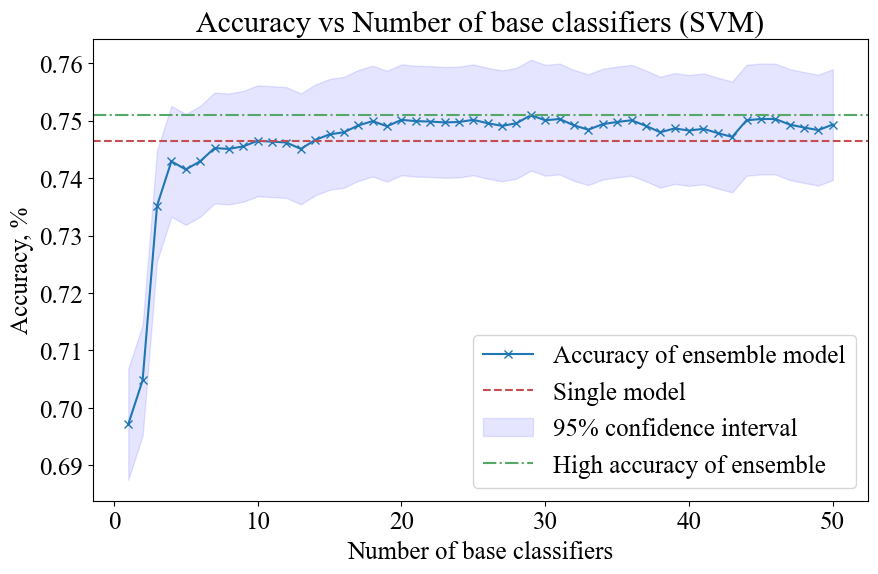

In [238]:
# Plot 1: No. of base classifiers Vs. accuracy
num_base_classifiers = np.arange(1, 51, 1)
ensemble_accuracies = []

for n in num_base_classifiers:
    model = BaggingClassifier(estimator=base_classifier, n_estimators=n, random_state=42,
                              max_samples=best_params['max_samples'], max_features=best_params['max_features'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ensemble_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(num_base_classifiers, ensemble_accuracies, 'x-', label='Accuracy of ensemble model')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Single model')
plt.fill_between(num_base_classifiers, np.array(ensemble_accuracies) - np.std(ensemble_accuracies),
                 np.array(ensemble_accuracies) + np.std(ensemble_accuracies), color='blue', alpha=0.1, label='95% confidence interval')
plt.axhline(y=max(ensemble_accuracies), color='g', linestyle='-.', label='High accuracy of ensemble')
plt.xlabel('Number of base classifiers')
plt.ylabel('Accuracy, %')
plt.legend(loc="lower right")
plt.title('Accuracy vs Number of base classifiers (ADB)')
plt.show()


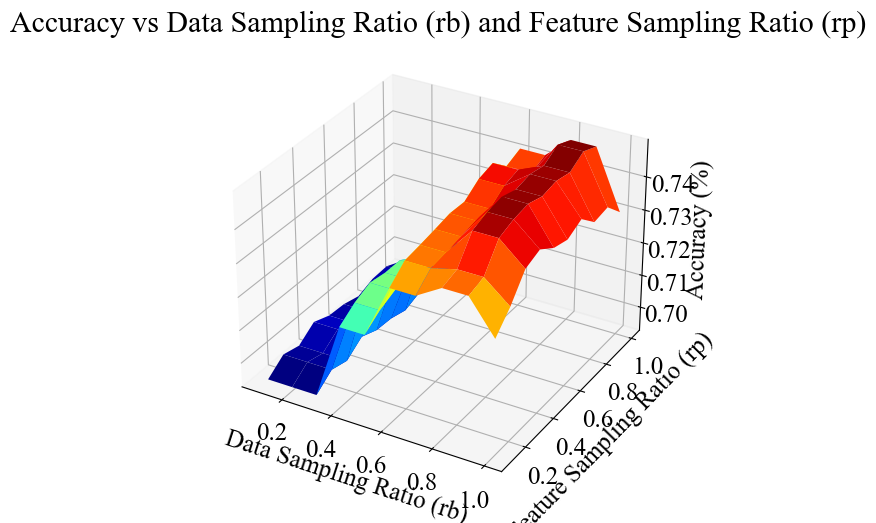

In [239]:
# Create a 3D plot for grid search results
results = grid_search.cv_results_
rb_values = param_grid['max_samples']
rp_values = param_grid['max_features']
accuracies = results['mean_test_score'].reshape(len(rb_values), len(rp_values))

rb_grid, rp_grid = np.meshgrid(rb_values, rp_values)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(rb_grid, rp_grid, accuracies.T, cmap='jet')

ax.set_xlabel('Data Sampling Ratio (rb)')
ax.set_ylabel('Feature Sampling Ratio (rp)')
ax.set_zlabel('Accuracy (%)')
ax.set_title('Accuracy vs Data Sampling Ratio (rb) and Feature Sampling Ratio (rp)')

plt.show()

**3. GBC as a base classifier**

In [474]:
base_classifier = GBC_CLF

In [24]:
# Define the BaggingClassifier
bagging_classifier = BaggingClassifier(estimator=base_classifier, random_state=42)

# Define the parameter grid
param_grid = {
    'max_samples': np.linspace(0.1, 1.0, 10),
    'max_features': np.linspace(0.1, 1.0, 10)
}

# Perform GridSearchCV to find optimal rb and rp
grid_search = GridSearchCV(bagging_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f'Optimal Data Sampling Ratio (rb): {best_params["max_samples"]}')
print(f'Optimal Feature Sampling Ratio (rp): {best_params["max_features"]}')
print(f'Best Cross-Validation Accuracy: {best_accuracy:.2f}')


In [475]:
# Train the final model with the best parameters
final_model_GBC = BaggingClassifier(
    estimator=base_classifier,
    max_samples=0.9,
    max_features=1.0,
    random_state=42
)
final_model_GBC.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_model_GBC.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')


Test Accuracy: 0.83


In [25]:
# # Plot 1: No. of base classifiers Vs. accuracy
# num_base_classifiers = np.arange(1, 51, 1)
# ensemble_accuracies = []

# for n in num_base_classifiers:
#     model = BaggingClassifier(estimator=base_classifier, n_estimators=n, random_state=42,
#                               max_samples=0.9, max_features=1.0)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     ensemble_accuracies.append(accuracy_score(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# plt.plot(num_base_classifiers, ensemble_accuracies, 'x-', label='Accuracy of ensemble model')
# plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Single model')
# plt.fill_between(num_base_classifiers, np.array(ensemble_accuracies) - np.std(ensemble_accuracies),
#                  np.array(ensemble_accuracies) + np.std(ensemble_accuracies), color='blue', alpha=0.1, label='95% confidence interval')
# plt.axhline(y=max(ensemble_accuracies), color='g', linestyle='-.', label='High accuracy of ensemble')
# plt.xlabel('Number of base classifiers')
# plt.ylabel('Accuracy, %')
# plt.legend(loc="lower right")
# plt.title('Accuracy vs Number of base classifiers (GBC)')
# plt.show()

# max_accuracy_index = np.argmax(ensemble_accuracies)
# optimal_num_classifiers = num_base_classifiers[max_accuracy_index]
# print(f"\nThe optimal number of base classifiers is {optimal_num_classifiers} with an accuracy of {ensemble_accuracies[max_accuracy_index]:.2f}")


In [26]:
# Create a 3D plot for grid search results
results = grid_search.cv_results_
rb_values = param_grid['max_samples']
rp_values = param_grid['max_features']
accuracies = results['mean_test_score'].reshape(len(rb_values), len(rp_values))

rb_grid, rp_grid = np.meshgrid(rb_values, rp_values)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(rb_grid, rp_grid, accuracies.T, cmap='jet')

ax.set_xlabel('Data Sampling Ratio (rb)')
ax.set_ylabel('Feature Sampling Ratio (rp)')
ax.set_zlabel('Accuracy (%)')
ax.set_title('Accuracy vs Data Sampling Ratio (rb) and Feature Sampling Ratio (rp)')

plt.show()

**4. XGB as a base classifier**

In [477]:
base_classifier = clf

In [246]:
# Define the BaggingClassifier
bagging_classifier = BaggingClassifier(estimator=base_classifier, random_state=42)

# Define the parameter grid
param_grid = {
    'max_samples': np.linspace(0.1, 1.0, 10),
    'max_features': np.linspace(0.1, 1.0, 10)
}

# Perform GridSearchCV to find optimal rb and rp
grid_search = GridSearchCV(bagging_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f'Optimal Data Sampling Ratio (rb): {best_params["max_samples"]}')
print(f'Optimal Feature Sampling Ratio (rp): {best_params["max_features"]}')
print(f'Best Cross-Validation Accuracy: {best_accuracy:.2f}')


Optimal Data Sampling Ratio (rb): 1.0
Optimal Feature Sampling Ratio (rp): 1.0
Best Cross-Validation Accuracy: 0.97


In [478]:
# Train the final model with the best parameters
final_model_XGB = BaggingClassifier(
    estimator=base_classifier,
    max_samples=1.0,
    max_features=1.0,
    random_state=42
)
final_model_XGB.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_model_XGB.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')


Test Accuracy: 0.98


In [27]:
# Plot 1: No. of base classifiers Vs. accuracy
num_base_classifiers = np.arange(1, 51, 1)
ensemble_accuracies = []

for n in num_base_classifiers:
    model = BaggingClassifier(estimator=base_classifier, n_estimators=n, random_state=42,
                              max_samples=1.0, max_features=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ensemble_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(num_base_classifiers, ensemble_accuracies, 'x-', label='Accuracy of ensemble model')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Single model')
plt.fill_between(num_base_classifiers, np.array(ensemble_accuracies) - np.std(ensemble_accuracies),
                 np.array(ensemble_accuracies) + np.std(ensemble_accuracies), color='blue', alpha=0.1, label='95% confidence interval')
plt.axhline(y=max(ensemble_accuracies), color='g', linestyle='-.', label='High accuracy of ensemble')
plt.xlabel('Number of base classifiers')
plt.ylabel('Accuracy, %')
plt.legend(loc="lower right")
plt.title('Accuracy vs Number of base classifiers (XGB)')
plt.show()

max_accuracy_index = np.argmax(ensemble_accuracies)
optimal_num_classifiers = num_base_classifiers[max_accuracy_index]
print(f"\nThe optimal number of base classifiers is {optimal_num_classifiers} with an accuracy of {ensemble_accuracies[max_accuracy_index]:.2f}")


In [28]:
# Create a 3D plot for grid search results
results = grid_search.cv_results_
rb_values = param_grid['max_samples']
rp_values = param_grid['max_features']
accuracies = results['mean_test_score'].reshape(len(rb_values), len(rp_values))

rb_grid, rp_grid = np.meshgrid(rb_values, rp_values)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(rb_grid, rp_grid, accuracies.T, cmap='jet')

ax.set_xlabel('Data Sampling Ratio (rb)')
ax.set_ylabel('Feature Sampling Ratio (rp)')
ax.set_zlabel('Accuracy (%)')
ax.set_title('Accuracy vs Data Sampling Ratio (rb) and Feature Sampling Ratio (rp)')

plt.show()

# Application of 4 trained homogeneous learners on blind wells (well-4, well-5)

**Random forest**

In [500]:
## Training
base_classifier = RFC_model

# Train the final model with the best parameters
RFC_hom_model = BaggingClassifier(
    estimator=base_classifier,
    max_samples=1.0,
    max_features=1.0, n_estimators=5,
    random_state=42
)
RFC_hom_model.fit(X_train, y_train)


BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_features='log2'),
                  n_estimators=5, random_state=42)

In [501]:
# Predict and evaluate on the test set
y_pred = RFC_hom_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9798


**Adaboost**

In [502]:
## Training
base_classifier = ADB_CLF

ADB_hom_model = BaggingClassifier(estimator=base_classifier, n_estimators=30, 
                                  random_state=42, max_samples=0.9, max_features=0.8)

ADB_hom_model.fit(X_train, y_train)


BaggingClassifier(estimator=AdaBoostClassifier(n_estimators=100),
                  max_features=0.8, max_samples=0.9, n_estimators=30,
                  random_state=42)

In [503]:
# Predict and evaluate on the test set
y_pred = ADB_hom_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7501


**Gradient boosting**

In [488]:
## Training
base_classifier = GBC_CLF

GBC_hom_model = BaggingClassifier(
    estimator=base_classifier,
    max_samples=0.9,
    max_features=1.0, n_estimators=20,
    random_state=42
)
GBC_hom_model.fit(X_train, y_train)


BaggingClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                       max_features='sqrt',
                                                       n_estimators=200,
                                                       subsample=0.9),
                  max_samples=0.9, n_estimators=20, random_state=42)

In [489]:
# Predict and evaluate on the test set
y_pred = GBC_hom_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.83


In [490]:
## Training
base_classifier = GradientBoostingClassifier()

GBC_hom_model_2 = BaggingClassifier(
    estimator=base_classifier,
    max_samples=0.9,
    max_features=1.0, n_estimators=20,
    random_state=42
)
GBC_hom_model_2.fit(X_train, y_train)


BaggingClassifier(estimator=GradientBoostingClassifier(), max_samples=0.9,
                  n_estimators=20, random_state=42)

**XG Boost**

In [492]:
## Training
base_classifier = clf

XGB_hom_model = BaggingClassifier(
    estimator=base_classifier,
    max_samples=1.0,
    max_features=1.0, n_estimators=37,
    random_state=42
)
XGB_hom_model.fit(X_train, y_train)


BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1.0, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.2, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          objective='multi:softprob', ...),
                  n_estimators=37, random_state=42)

In [493]:
# Predict and evaluate on the test set
y_pred = XGB_hom_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.98


#### Predicting facies for blind well by all HOMOGENEOUS models

In [504]:
## Well-4
#RFC
yhat_blind_RFC_hom = RFC_hom_model.predict(X_blind)
Blind_Testing_df['RFC_Pred_hom'] = yhat_blind_RFC_hom


In [561]:
# Evaluating the homogeneous random forest model on the blind well-4 dataset
f1RFC_b_hom = f1_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df['RFC_Pred_hom'], average='weighted')
print(f'Homogeneous random forest model F1 Score: {f1RFC_b_hom:.4f}')

Homogeneous random forest model F1 Score: 0.8508


In [505]:
## Well-5
#RFC
yhat_blind_RFC_hom_2 = RFC_hom_model.predict(X_blind_2)
Blind_Testing_df_2['RFC_Pred_hom'] = yhat_blind_RFC_hom_2


In [506]:
## Well-4
#ADB
yhat_blind_ADB_hom = ADB_hom_model.predict(X_blind)
Blind_Testing_df['ADB_Pred_hom'] = yhat_blind_ADB_hom


In [562]:
# Evaluating the homogeneous adaboost model on the blind well-4 dataset
f1ADB_b_hom = f1_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df['ADB_Pred_hom'], average='weighted')
print(f'Homogeneous AdaBoost model F1 Score: {f1ADB_b_hom:.4f}')

Homogeneous AdaBoost model F1 Score: 0.8441


In [507]:
## Well-5
#ADB
yhat_blind_ADB_hom_2 = ADB_hom_model.predict(X_blind_2)
Blind_Testing_df_2['ADB_Pred_hom'] = yhat_blind_ADB_hom_2


In [508]:
# Well-4
#GBC
yhat_blind_GBC_hom = GBC_hom_model.predict(X_blind)
Blind_Testing_df['GBC_Pred_hom'] = yhat_blind_GBC_hom


In [563]:
# Evaluating the homogeneous GBC model on the blind well-4 dataset
f1GBC_b_hom = f1_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df['GBC_Pred_hom'], average='weighted')
print(f'Homogeneous GBC model F1 Score: {f1GBC_b_hom:.4f}')

Homogeneous GBC model F1 Score: 0.8505


In [509]:
## Well-5
#GBC
yhat_blind_GBC_hom_2 = GBC_hom_model.predict(X_blind_2)
Blind_Testing_df_2['GBC_Pred_hom'] = yhat_blind_GBC_hom_2


In [510]:
## Well-4
#XGB
yhat_blind_XGB_hom = XGB_hom_model.predict(X_blind)
Blind_Testing_df['XGB_Pred_hom'] = yhat_blind_XGB_hom


In [564]:
# Evaluating the homogeneous XGB model on the blind well-4 dataset
f1XGB_b_hom = f1_score(Blind_Testing_df['Encoded_Formation'], Blind_Testing_df['XGB_Pred_hom'], average='weighted')
print(f'Homogeneous XGB model F1 Score: {f1XGB_b_hom:.4f}')

Homogeneous XGB model F1 Score: 0.8431


In [511]:
## Well-5
#XGB
yhat_blind_XGB_hom_2 = XGB_hom_model.predict(X_blind_2)
Blind_Testing_df_2['XGB_Pred_hom'] = yhat_blind_XGB_hom_2


In [29]:
compare_facies_plot(Blind_Testing_df, 'RFC_Pred_hom', facies_colors)


In [30]:
compare_facies_plot(Blind_Testing_df, 'ADB_Pred_hom', facies_colors)


In [31]:
compare_facies_plot(Blind_Testing_df, 'GBC_Pred_hom', facies_colors)


In [32]:
compare_facies_plot(Blind_Testing_df, 'XGB_Pred_hom', facies_colors)


#### Recreate dataframe of model evaluation for blind (well-4) performance

**Organizing the accuracy scores of all the models (upto the heterogeneous ensemble)**

In [546]:
Blind_Testing_df

,DEPTH,NGAM,CALP,SPR,SHN_LONG_AVG,LSD_HRD_AVG,Encoded_Formation,SVM_Pred,RFC_Pred,GBC_Pred,DT_Pred,ADB_Pred,XGB_Pred,Stack_pred,Het_ensmble_Pred,XGB_Pred_hom,ADB_Pred_hom,RFC_Pred_hom,GBC_Pred_hom
0,54.00,107.924,78.913,9.582,107.6545,2.5965,2,2,2,2,2,2,2,2,2,2,2,2,2
1,54.01,104.797,78.904,9.618,107.6545,2.6000,2,2,2,2,2,2,2,2,2,2,2,2,2
2,54.02,108.281,78.913,9.655,107.6545,2.6105,2,2,2,2,2,2,2,2,2,2,2,2,2
3,54.03,112.458,78.913,9.691,107.6545,2.6065,2,2,2,2,2,2,2,2,2,2,2,2,2
4,54.04,108.982,78.926,9.727,107.0730,2.6085,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45798,527.96,80.207,57.758,15.655,18.3455,2.7605,2,4,2,2,2,2,2,4,2,2,2,2,2
45799,527.97,78.114,57.758,15.564,18.2635,2.7355,2,2,2,2,2,2,2,2,2,2,2,2,2
45800,527.98,80.207,57.758,15.527,18.1635,2.7140,2,2,2,2,2,2,2,2,2,2,2,2,2
45801,527.99,82.299,57.736,15.491,18.1640,2.6800,2,2,2,2,2,2,2,2,2,2,2,2,2


In [547]:
Acc_score_SVM = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["SVM_Pred"])
print(Acc_score_SVM)

0.7675698098377836


In [548]:
Acc_score_RFC = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["RFC_Pred"])
print(Acc_score_RFC)

0.865641988516036


In [549]:
Acc_score_GBC = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["GBC_Pred"])
print(Acc_score_GBC)

0.8723882715105997


In [550]:
Acc_score_DT = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["DT_Pred"])
print(Acc_score_DT)

0.7681156256140428


In [551]:
Acc_score_ADB = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["ADB_Pred"])
print(Acc_score_ADB)

0.8264305831495754


In [552]:
Acc_score_XGB = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["XGB_Pred"])
print(Acc_score_XGB)

0.8587865423662205


In [553]:
Acc_score_Stack = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["Stack_pred"])
print(Acc_score_Stack)

0.8427177259131498


In [554]:
Acc_score_Het = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["Het_ensmble_Pred"])
print(Acc_score_Het)

0.9087177695784119


In [555]:
Acc_score_hom_RFC = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["RFC_Pred_hom"])
print(Acc_score_hom_RFC)

0.8702268410366133


In [556]:
Acc_score_hom_ADB = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["ADB_Pred_hom"])
print(Acc_score_hom_ADB)

0.8579132371242059


In [557]:
Acc_score_hom_GBC = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["GBC_Pred_hom"])
print(Acc_score_hom_GBC)

0.8764054756238674


In [558]:
Acc_score_hom_XGB = accuracy_score(Blind_Testing_df["Encoded_Formation"], Blind_Testing_df["XGB_Pred_hom"])
print(Acc_score_hom_XGB)

0.8648996790603236


In [569]:
data_frame4 = {
    'Model type': ['SVM', 'RFC', 'GBC', 'DT', 'ADB', 'XGB', 'Stack', 'Heterogeneous', 
                   'RFC_Homogeneous', 'ADB_Homogeneous', 'GBC_Homogeneous', 'XGB_Homogeneous'],
    'Accuracy score': [Acc_score_SVM, Acc_score_RFC, Acc_score_GBC, Acc_score_DT, Acc_score_ADB, Acc_score_XGB, 
                       Acc_score_Stack, Acc_score_Het, Acc_score_hom_RFC, Acc_score_hom_ADB, Acc_score_hom_GBC, Acc_score_hom_XGB],
    'Overall F1-Score': [f1SVM_b, f1RFC_b, f1GBC_b, f1DT_b, f1ADB_b, f1XGB_b, f1_stack, f1_het, 
                        f1RFC_b_hom, f1ADB_b_hom, f1GBC_b_hom, f1XGB_b_hom]
}

df4 = pd.DataFrame(data_frame4, columns=['Model type', 'Accuracy score', 'Overall F1-Score'])
df4_sorted = df4.sort_values(by='Overall F1-Score', ascending=False)

print(df4_sorted.round(5))


         Model type  Accuracy score  Overall F1-Score
7     Heterogeneous         0.90872           0.89443
6             Stack         0.84272           0.85865
8   RFC_Homogeneous         0.87023           0.85078
10  GBC_Homogeneous         0.87641           0.85053
1               RFC         0.86564           0.85047
9   ADB_Homogeneous         0.85791           0.84410
11  XGB_Homogeneous         0.86490           0.84311
5               XGB         0.85879           0.84283
2               GBC         0.87239           0.84118
4               ADB         0.82643           0.82928
3                DT         0.76812           0.79064
0               SVM         0.76757           0.74977


In [9]:
df4 = pd.read_excel(r'G:\Geophysics\6. PHD\Coal work\Training wells\Main files copy\df4.xlsx')
df4

,Model type,Accuracy score,Overall F1-Score
0,SVM,0.76757,0.74977
1,RFC,0.86564,0.85047
2,GBC,0.87239,0.84118
3,DT,0.76812,0.79064
4,ADB,0.82643,0.82928
5,XGB,0.85879,0.84283
6,Stack,0.84272,0.85865
7,Heterogeneous,0.90872,0.89443
8,RFC_Homogeneous,0.87023,0.85078
9,ADB_Homogeneous,0.85791,0.84410


### Overall model performances of all the single, homogeneous, stack and heterogeneous models in terms of accuracy and f1-score

In [10]:
# Group models
groups = [
    ('SVM', None), 
    ('DT', None), 
    ('RFC', 'RFC_Homogeneous'), 
    ('GBC', 'GBC_Homogeneous'), 
    ('ADB', 'ADB_Homogeneous'), 
    ('XGB', 'XGB_Homogeneous'), 
    ('Stack', None), 
    ('Heterogeneous', None)
]

# Set colors for different model types
colors = {
    'SVM': 'blue', 'DT': 'blue', 'RFC': 'blue', 'GBC': 'blue', 'ADB': 'blue', 'XGB': 'blue',
    'RFC_Homogeneous': 'limegreen', 'ADB_Homogeneous': 'limegreen', 'GBC_Homogeneous': 'limegreen', 'XGB_Homogeneous': 'limegreen',
    'Stack': 'red', 'Heterogeneous': 'red'
}


In [11]:
# Plot Accuracy score
fig, ax = plt.subplots(figsize=(14, 6))

x_pos = np.arange(len(groups))
width = 0.35

for i, (base_model, hom_model) in enumerate(groups):
    if base_model:
        base_value = df4[df4['Model type'] == base_model]['Accuracy score'].values[0]
        ax.bar(x_pos[i] - width/2, base_value, width, label=base_model, color=colors[base_model])
    if hom_model:
        hom_value = df4[df4['Model type'] == hom_model]['Accuracy score'].values[0]
        ax.bar(x_pos[i] + width/2, hom_value, width, label=hom_model, color=colors[hom_model])

ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Accuracy Score', fontsize=16)
ax.set_ylim(0.5, 1)
ax.set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=15)
ax.set_title('Models vs. Accuracy Score', fontsize=18)
ax.set_xticks(x_pos)
ax.set_xticklabels([base for base, hom in groups], rotation=90, ha='right', fontsize=15)

# Place the legend outside of the main plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()

In [12]:
# Plot Overall F1-Score
fig, ax = plt.subplots(figsize=(14, 6))

x_pos = np.arange(len(groups))
width = 0.35

for i, (base_model, hom_model) in enumerate(groups):
    if base_model:
        base_value = df4[df4['Model type'] == base_model]['Overall F1-Score'].values[0]
        ax.bar(x_pos[i] - width/2, base_value, width, label=base_model, color=colors[base_model])
    if hom_model:
        hom_value = df4[df4['Model type'] == hom_model]['Overall F1-Score'].values[0]
        ax.bar(x_pos[i] + width/2, hom_value, width, label=hom_model, color=colors[hom_model])

ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Overall F1-Score', fontsize=16)
ax.set_ylim(0.5, 1)
ax.set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=15)
ax.set_title('Models vs. Overall F1-Score', fontsize=18)
ax.set_xticks(x_pos)
ax.set_xticklabels([base for base, hom in groups], rotation=90, ha='right', fontsize=15)

# Place the legend outside of the main plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()

## Constructing confusion matrix for homogeneous ensemble methods

In [ ]:
# RFC Homogeneous
conf_RFC_hom_b_test = confusion_matrix(y_blind, yhat_blind_RFC_hom)
display_cm(conf_RFC_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_RFC_hom_b_test = display_cm_as_dataframe(conf_RFC_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_RFC_hom_b_test)


# ADB Homogeneous
conf_ADB_hom_b_test = confusion_matrix(y_blind, yhat_blind_ADB_hom)
display_cm(conf_ADB_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_ADB_hom_b_test = display_cm_as_dataframe(conf_ADB_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_ADB_hom_b_test)


# GBC Homogeneous
conf_GBC_hom_b_test = confusion_matrix(y_blind, yhat_blind_GBC_hom)
display_cm(conf_GBC_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_GBC_hom_b_test = display_cm_as_dataframe(conf_GBC_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_GBC_hom_b_test)


# XGB Homogeneous
conf_XGB_hom_b_test = confusion_matrix(y_blind, yhat_blind_XGB_hom)
display_cm(conf_XGB_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
df_conf_XGB_hom_b_test = display_cm_as_dataframe(conf_XGB_hom_b_test, facies_labels, hide_zeros=True, display_metrics=True)
print(df_conf_XGB_hom_b_test)

### Overall performance of the homogeneous ensemble classifiers compared with their respective single classifier counterparts 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual data)
models = ['RFC', 'RFC_hom', 'ADB', 'ADB_hom', 'GBC', 'GBC_hom', 'XGB', 'XGB_hom']
accuracy_single = [0.8656, 0.8264, 0.8723, 0.8587]
accuracy_homogeneous = [0.8702, 0.8579, 0.8764, 0.8648]
precision_single = [0.8380, 0.8340, 0.8272, 0.8330]
precision_homogeneous = [0.8382, 0.8316, 0.8383, 0.8275]
recall_single = [0.8656, 0.8264, 0.8724, 0.8588]
recall_homogeneous = [0.8702, 0.8579, 0.8764, 0.8649]
f1_score_single = [0.8504, 0.8292, 0.8412, 0.8428]
f1_score_homogeneous = [0.8507, 0.8441, 0.8505, 0.8431]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# A. Accuracy subplot
axs[0, 0].bar(np.arange(len(models)//2), accuracy_single, width=0.4, label='Single Classifier', color='gold')
axs[0, 0].bar(np.arange(len(models)//2)+0.4, accuracy_homogeneous, width=0.4, label='Homogeneous Model', color='limegreen')
axs[0, 0].set_title('Accuracy', fontsize=18)
axs[0, 0].set_xticks(np.arange(len(models)//2)+0.2)
axs[0, 0].set_xticklabels(models[::2], rotation=45, fontsize=17)
axs[0, 0].set_ylim(0.8, 0.9)
axs[0, 0].set_yticklabels(labels=[0.80, 0.82, 0.84, 0.86, 0.88, 0.90], fontsize=17)
#axs[0, 0].legend()

# B. Precision subplot
axs[0, 1].bar(np.arange(len(models)//2), precision_single, width=0.4, label='Single Classifier', color='gold')
axs[0, 1].bar(np.arange(len(models)//2)+0.4, precision_homogeneous, width=0.4, label='Homogeneous Model', color='limegreen')
axs[0, 1].set_title('Precision', fontsize=18)
axs[0, 1].set_xticks(np.arange(len(models)//2)+0.2)
axs[0, 1].set_xticklabels(models[::2], rotation=45, fontsize=17)
axs[0, 1].set_ylim(0.8, 0.9)
axs[0, 1].set_yticklabels(labels=[0.80, 0.82, 0.84, 0.86, 0.88, 0.90], fontsize=17)
axs[0, 1].legend(fontsize=18)  # Increase fontsize of the legend

# C. Recall subplot
axs[1, 0].bar(np.arange(len(models)//2), recall_single, width=0.4, label='Single Classifier', color='gold')
axs[1, 0].bar(np.arange(len(models)//2)+0.4, recall_homogeneous, width=0.4, label='Homogeneous Model', color='limegreen')
axs[1, 0].set_title('Recall', fontsize=18)
axs[1, 0].set_xticks(np.arange(len(models)//2)+0.2)
axs[1, 0].set_xticklabels(models[::2], rotation=45, fontsize=17)
axs[1, 0].set_ylim(0.8, 0.9)
axs[1, 0].set_yticklabels(labels=[0.80, 0.82, 0.84, 0.86, 0.88, 0.90], fontsize=17)
#axs[1, 0].legend()

# D. F1-Score subplot
axs[1, 1].bar(np.arange(len(models)//2), f1_score_single, width=0.4, label='Single Classifier', color='gold')
axs[1, 1].bar(np.arange(len(models)//2)+0.4, f1_score_homogeneous, width=0.4, label='Homogeneous Model', color='limegreen')
axs[1, 1].set_title('F1-Score', fontsize=18)
axs[1, 1].set_xticks(np.arange(len(models)//2)+0.2)
axs[1, 1].set_xticklabels(models[::2], rotation=45, fontsize=17)
axs[1, 1].set_ylim(0.8, 0.9)
axs[1, 1].set_yticklabels(labels=[0.80, 0.82, 0.84, 0.86, 0.88, 0.90], fontsize=17)
#axs[1, 1].legend()

plt.tight_layout()
plt.show()


## Evaluation of model performance on blind testing well-5 using Cohen's kappa, accuracy score similarity matrices

In [517]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, accuracy_score
from scipy.spatial.distance import jaccard

# Assuming Blind_Testing_df is your dataframe containing the predictions
columns = ["SVM_Pred", "RFC_Pred", "DT_Pred", "GBC_Pred", "ADB_Pred", "XGB_Pred", "Stack_pred", "Het_ensmble_Pred", 
           "RFC_Pred_hom", "ADB_Pred_hom", "GBC_Pred_hom", "XGB_Pred_hom"]

# Initialize a dataframe to store the similarity metrics
similarity_matrix = pd.DataFrame(index=columns, columns=columns)

# Calculate pairwise Cohen's Kappa
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            similarity_matrix.loc[col1, col2] = 1.0  # similarity with itself
        else:
            kappa = cohen_kappa_score(Blind_Testing_df[col1], Blind_Testing_df[col2])
            similarity_matrix.loc[col1, col2] = kappa

print("Pairwise Cohen's Kappa:")
print(similarity_matrix)

# Calculate pairwise accuracy score
accuracy_matrix = pd.DataFrame(index=columns, columns=columns)
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            accuracy_matrix.loc[col1, col2] = 1.0  # similarity with itself
        else:
            accuracy = accuracy_score(Blind_Testing_df[col1], Blind_Testing_df[col2])
            accuracy_matrix.loc[col1, col2] = accuracy

print("\nPairwise Accuracy Score:")
print(accuracy_matrix)

# Calculate pairwise Jaccard similarity
jaccard_matrix = pd.DataFrame(index=columns, columns=columns)
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            jaccard_matrix.loc[col1, col2] = 1.0  # similarity with itself
        else:
            jaccard_sim = 1 - jaccard(Blind_Testing_df[col1], Blind_Testing_df[col2])
            jaccard_matrix.loc[col1, col2] = jaccard_sim

print("\nPairwise Jaccard Similarity:")
print(jaccard_matrix)

# Optionally, calculate Pearson correlation coefficient
correlation_matrix = Blind_Testing_df[columns].corr()

print("\nPairwise Pearson Correlation Coefficient:")
print(correlation_matrix)


Pairwise Cohen's Kappa:
                  SVM_Pred  RFC_Pred   DT_Pred  GBC_Pred  ADB_Pred  XGB_Pred  \
SVM_Pred               1.0  0.303871  0.181681  0.159252  0.192806  0.200872   
RFC_Pred          0.303871       1.0  0.447515  0.677751  0.520103  0.671435   
DT_Pred           0.181681  0.447515       1.0  0.364989  0.376049  0.417824   
GBC_Pred          0.159252  0.677751  0.364989       1.0  0.537007  0.685472   
ADB_Pred          0.192806  0.520103  0.376049  0.537007       1.0  0.575308   
XGB_Pred          0.200872  0.671435  0.417824  0.685472  0.575308       1.0   
Stack_pred        0.330754  0.504408  0.362855  0.417347  0.562362  0.441975   
Het_ensmble_Pred  0.121363  0.698559  0.404607  0.696878  0.561351  0.697043   
RFC_Pred_hom      0.305357  0.889825  0.445514  0.722541  0.509692  0.696595   
ADB_Pred_hom      0.142997  0.589974  0.366145  0.654214  0.718309  0.657189   
GBC_Pred_hom      0.165807  0.706455   0.38803   0.92662  0.574229  0.701038   
XGB_Pred_hom    

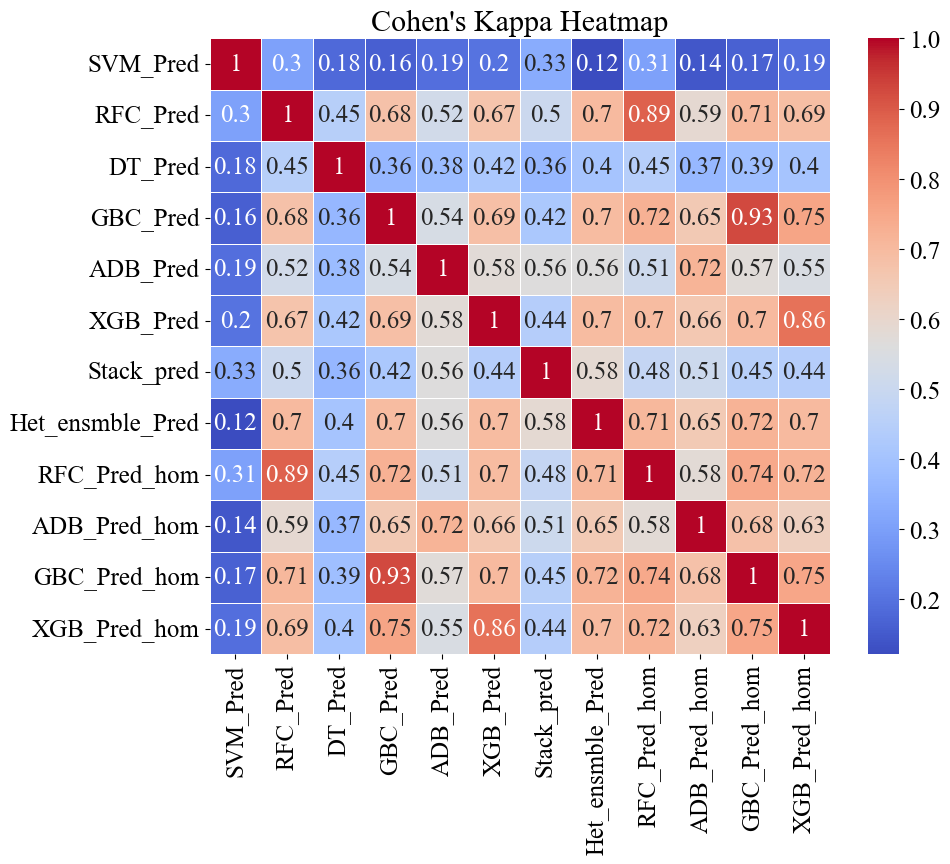

In [518]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the heatmap for Cohen's Kappa
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cohen's Kappa Heatmap")
plt.show()


In [14]:
# Generate the heatmap for Accuracy matrix
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Accuracy matrix Heatmap")
plt.show()


### On blind testing well-5

In [525]:
# Assuming Blind_Testing_df_2 is your dataframe containing the predictions
columns = ["SVM_Pred", "RFC_Pred", "DT_Pred", "GBC_Pred", "ADB_Pred", "XGB_Pred", "Stack_pred", "Het_ensmble_Pred", 
           "RFC_Pred_hom", "ADB_Pred_hom", "GBC_Pred_hom", "XGB_Pred_hom"]

# Initialize a dataframe to store the similarity metrics
similarity_matrix = pd.DataFrame(index=columns, columns=columns)

# Calculate pairwise Cohen's Kappa
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            similarity_matrix.loc[col1, col2] = 1.0  # similarity with itself
        else:
            kappa = cohen_kappa_score(Blind_Testing_df_2[col1], Blind_Testing_df_2[col2])
            similarity_matrix.loc[col1, col2] = kappa

print("Pairwise Cohen's Kappa:")
print(similarity_matrix)

# Calculate pairwise accuracy score
accuracy_matrix = pd.DataFrame(index=columns, columns=columns)
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            accuracy_matrix.loc[col1, col2] = 1.0  # similarity with itself
        else:
            accuracy = accuracy_score(Blind_Testing_df_2[col1], Blind_Testing_df_2[col2])
            accuracy_matrix.loc[col1, col2] = accuracy

print("\nPairwise Accuracy Score:")
print(accuracy_matrix)

# Calculate pairwise Jaccard similarity
jaccard_matrix = pd.DataFrame(index=columns, columns=columns)
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            jaccard_matrix.loc[col1, col2] = 1.0  # similarity with itself
        else:
            jaccard_sim = 1 - jaccard(Blind_Testing_df_2[col1], Blind_Testing_df_2[col2])
            jaccard_matrix.loc[col1, col2] = jaccard_sim

print("\nPairwise Jaccard Similarity:")
print(jaccard_matrix)

# Optionally, calculate Pearson correlation coefficient
correlation_matrix = Blind_Testing_df_2[columns].corr()

print("\nPairwise Pearson Correlation Coefficient:")
print(correlation_matrix)


Pairwise Cohen's Kappa:
                  SVM_Pred  RFC_Pred   DT_Pred  GBC_Pred  ADB_Pred  XGB_Pred  \
SVM_Pred               1.0  0.348695  0.289563  0.351134  0.387104  0.354945   
RFC_Pred          0.348695       1.0  0.636945   0.75587  0.647259  0.824341   
DT_Pred           0.289563  0.636945       1.0  0.635187   0.55315  0.657649   
GBC_Pred          0.351134   0.75587  0.635187       1.0  0.741373  0.812294   
ADB_Pred          0.387104  0.647259   0.55315  0.741373       1.0  0.709762   
XGB_Pred          0.354945  0.824341  0.657649  0.812294  0.709762       1.0   
Stack_pred        0.568127  0.347703  0.373523   0.33796  0.381158  0.365833   
Het_ensmble_Pred   0.28883  0.748578   0.64704  0.748882  0.673666  0.811953   
RFC_Pred_hom      0.345629   0.92361  0.647757  0.779251  0.654653  0.819831   
ADB_Pred_hom      0.326846  0.669703  0.577054  0.751331  0.847291  0.724163   
GBC_Pred_hom      0.374941  0.756081  0.644238  0.924724  0.780475  0.811431   
XGB_Pred_hom    

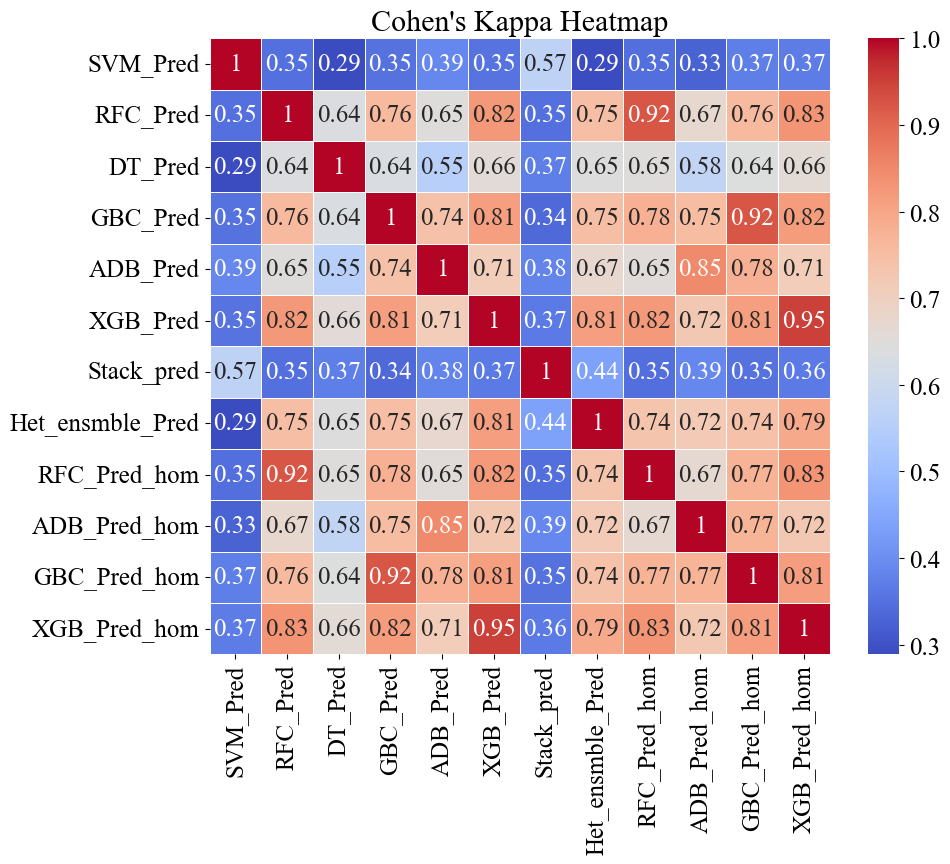

In [526]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the heatmap for Cohen's Kappa
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cohen's Kappa Heatmap")
plt.show()


In [13]:
# Generate the heatmap for Accuracy matrix
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Accuracy matrix Heatmap")
plt.show()
